<a href="https://colab.research.google.com/github/HechengJin0/MGC_paper/blob/master/paper_figures_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set env

In [1]:
!pip install nibabel
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 41.5 MB/s eta 0:00:00


In [2]:
!pip install hyppo==0.1.3

  Preparing metadata (setup.py) ... done
  Created wheel for hyppo: filename=hyppo-0.1.3-py3-none-any.whl size=64196 sha256=9712dba85b49de4c431f547bd5fb77fbc13c2ee68af57234ae026186042096eb
  Stored in directory: /root/.cache/pip/wheels/95/ea/1a/eff107e2996f700eb254725609327d61f40e047c3bf995cad6
Successfully built hyppo


In [3]:
def parcel2vert(wdir,lsurf,plabel,theta_img):
    # glasserlabel,(ax1,ax2) = cifti.read(plabel)
    cifti_plabel = nib.load(plabel)
    glasserlabel = cifti_plabel.get_fdata()
    numverts = int(glasserlabel.shape[1]/2)
    if len(theta_img.shape) >1:
        numparcels = len(theta_img)
    else:
        numparcels = 1
        theta_img = np.reshape(theta_img,[-1,len(theta_img)])
    nparc = np.arange(numparcels)
    data = np.zeros([numparcels,numverts])
    for parcel in nparc:
        for plabel in range(int(np.max((glasserlabel)/2))): #note: 32k hcp map weried, , so hardcode 180
            p_idx = np.where(glasserlabel[0,:]==plabel+1)
            data[parcel,p_idx] = theta_img[parcel,plabel]
    return data

def parcel2vert_r(wdir,rsurf,plabel,theta_img):
    # glasserlabel,(ax1,ax2) = cifti.read(plabel)
    cifti_plabel = nib.load(plabel)
    glasserlabel = cifti_plabel.get_fdata()
    numverts = int(glasserlabel.shape[1]/2)
    if len(theta_img.shape) >1:
        numparcels = len(theta_img)
    else:
        numparcels = 1
        theta_img = np.reshape(theta_img,[-1,len(theta_img)])
    nparc = np.arange(numparcels)
    data = np.zeros([numparcels,numverts])
    for parcel in nparc:
        for plabel in range(int(np.max((glasserlabel)/2)), int(np.max((glasserlabel)))):
            p_idx = np.where(glasserlabel[0,:]==plabel+1)
            j = int(glasserlabel.shape[1]/2)
            p_idx_new = tuple(map(lambda i: i-j, p_idx))
            plabel = plabel-int(p/2)
            data[parcel,p_idx_new] = theta_img[parcel,plabel]
    return data

In [4]:
!pip install graspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for graspy: filename=graspy-0.3.0-py3-none-any.whl size=115225 sha256=15f5aee24fc71f6372134ea1e61d844b3bd7718c28fd9dea01ca9266ace9a389
  Stored in directory: /root/.cache/pip/wheels/2d/61/15/c75a68f510098602242ca7fdf935e86a3e1c86f5230b65ba84
Successfully built graspy


In [5]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

In [6]:
import pickle

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
from scipy.stats import pearsonr, zscore
import seaborn as sns

In [8]:
from hyppo.independence import MGC
from hyppo.time_series import MGCX

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Fig 1A

In [ ]:
roi = pd.read_csv("/gdrive/My Drive/CMI/Project/MGCX/data/HCPMMP_To_Yeo7_LR.csv")
roi_labels_R = np.asarray(roi[180:360]["Yeo7Network_keys"]) #left X
roi_labels_L = np.asarray(roi[0:180]["Yeo7Network_keys"]) #right Y
roi_labels = np.asarray(roi["Yeo7Network_keys"], dtype=str) # all

In [ ]:
roi_plot = []
for i in range(len(roi_labels)):
  if roi_labels[i] == "1": #1 is vis , #7 is default
    roi_plot.append(1)
  else:
    roi_plot.append(0)
roi_plot_dmn = []
for i in range(len(roi_labels)):
  if roi_labels[i] == "7": #1 is vis , #7 is default
    roi_plot_dmn.append(1)
  else:
    roi_plot_dmn.append(0)


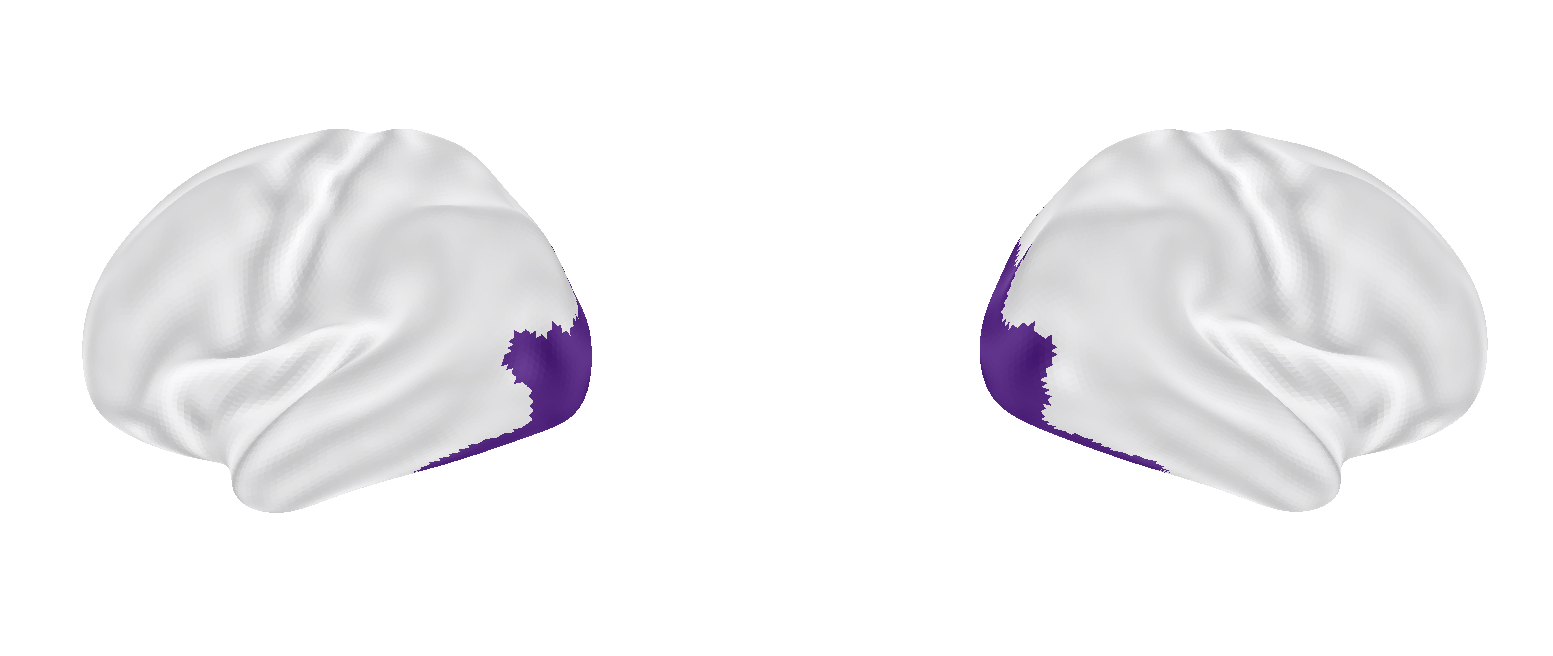

In [ ]:
%matplotlib inline
wdir = '/gdrive/My Drive/CMI/Project/MGCX/data'
parcel_label = plabel = '%s/HCP_MMP_P210_10k.dlabel.nii' % wdir
rightsurface = rsurf='/gdrive/My Drive/CMI/Project/MGCX/data/10k/Conte69.R.very_inflated.10k_fs_LR.surf.gii'
leftsurface = lsurf = '/gdrive/My Drive/CMI/Project/MGCX/data/10k/Conte69.L.very_inflated.10k_fs_LR.surf.gii'

p=360
img_optimal_scale_X_mean = parcel2vert(wdir,lsurf,parcel_label,np.array(roi_plot[180:360]).reshape(1,180)) #[0:180]
img_optimal_scale_X_mean_r = parcel2vert_r(wdir,rsurf,parcel_label,np.array(roi_plot[0:180]).reshape(1,180))


cmap = 'Purples'

vmax = 1
vmin = 0
j=1
plt.figure(figsize=(20,20/3))
views = ['lateral']
bg_map = '/gdrive/My Drive/CMI/Project/MGCX/data/10k/S1200.L.curvature_MSMAll.10k_fs_LR.func.gii'

# show left 'lateral', 'medial' 2*1
for v in views:

    ax = plt.subplot(1,2,j, projection='3d')
    plotting.plot_surf(leftsurface, img_optimal_scale_X_mean, bg_map=bg_map, bg_on_data=True,hemi='left',view = v, cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 1, symmetric_cmap=False,axes=ax)

    ax = plt.subplot(1,2,j+1, projection='3d')
    plotting.plot_surf(rightsurface, img_optimal_scale_X_mean_r, bg_map=bg_map, bg_on_data=True,hemi='right',view = v, cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 1, symmetric_cmap=False,axes=ax)


    j+=1

plt.tight_layout()
plt.show()




### MGC example


In [ ]:
img = nib.load("/gdrive/My Drive/CMI/Project/MGCX/data/HCP_trt/HCP_trt_07012020/test/103818/rfMRI_REST1_LR/gsr/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_24nuisance.gsr.reg_lin.trend_filt_sm6.ptseries.nii")

data_org = np.array(img.get_fdata())

tr=200
parcel_index_1=0 # R_vis:0
parcel_index_2=194 # L_dmn:194 L_vis: 0+180
axis= 0
data = zscore(data_org,axis=axis)

X = data[0:tr,parcel_index_1].reshape(tr, 1)
Y = data[0:tr,parcel_index_2].reshape(tr, 1)

# test_statistic_x, opt_lag, opt_scale = mgcx.statistic(X, Y)
# optimal_scale_X = opt_scale[0]
# optimal_scale_Y = opt_scale[1]

mgc = MGC()
mgc_stat,mgc_pvalue,mgc_dict = mgc.test(X, Y)
local_correlation_matrix = mgc_dict["mgc_map"]
optimal_scale_X = mgc_dict["opt_scale"][0]
optimal_scale_Y = mgc_dict["opt_scale"][1]



(-120.0, 120.0)

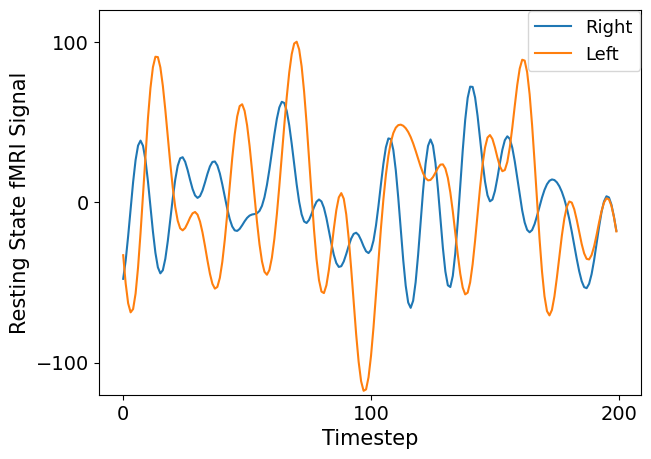

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
ax.plot(data_org[0:tr,parcel_index_1], label="Right")
ax.plot(data_org[0:tr,parcel_index_2], label="Left")
plt.ylabel('Resting State fMRI Signal', fontsize = 15)
plt.xlabel('Timestep', fontsize = 15)
ax.legend(loc="upper right", fontsize = 13,bbox_to_anchor=(1.015, 1.02))
ax.set_xticks([0,100,200])
ax.set_yticks([-100, 0, 100])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-120,120)

# plt.ylim(-90,90)

(-130.0, 130.0)

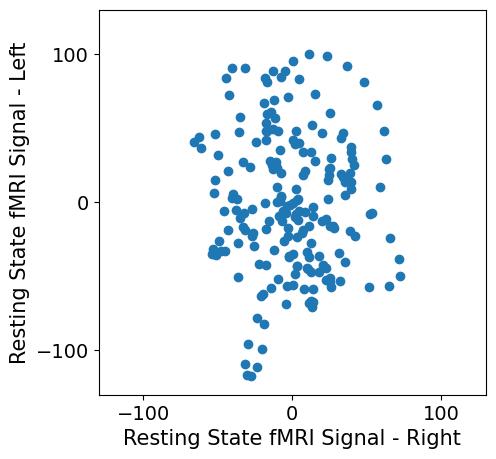

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.scatter(data_org[0:tr,parcel_index_1], data_org[0:tr,parcel_index_2])
plt.ylabel('Resting State fMRI Signal - Left', fontsize = 15)
plt.xlabel('Resting State fMRI Signal - Right', fontsize = 15)
# plt.ylim(-90,90)
# plt.xlim(-90,90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xticks([-100, 0, 100])
ax.set_yticks([-100, 0, 100])
plt.ylim(-130,130)
plt.xlim(-130,130)

In [ ]:
np.max(local_correlation_matrix)

0.4914196336197872

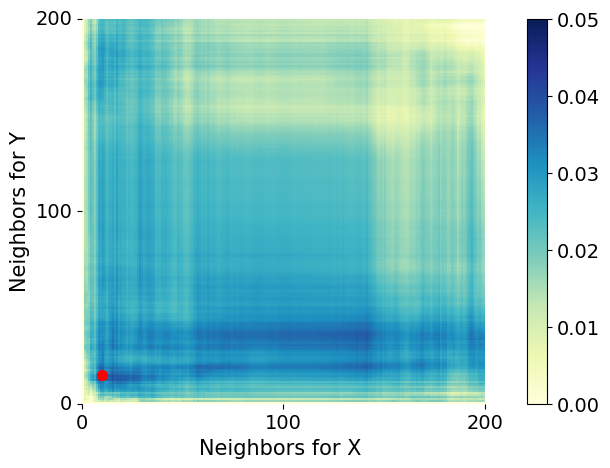

In [ ]:
import matplotlib.ticker as ticker
corr_map_lim = 0.05 #0.05 for nonlinear, 0.5for linear

y = optimal_scale_X
x = optimal_scale_Y
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(6, 5),  gridspec_kw={"width_ratios":[1, 0.05]}) #(9.45, 7.5)
ax = sns.heatmap(local_correlation_matrix, cmap="YlGnBu", ax=ax, cbar=False)
ax.invert_yaxis()
ax.scatter(x, y, marker='o', s=50, color='red')

cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
cbar.mappable.set_clim(0,corr_map_lim)

# other formatting
axis_ticker = 1
# ax.set_title("MGC Map",fontsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(axis_ticker))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(axis_ticker))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Neighbors for X ', fontsize=15)
ax.set_ylabel('Neighbors for Y', fontsize=15)
ax.set_xticks([0, 100, 200])
ax.set_yticks([0, 100, 200])
ax.xaxis.set_tick_params(rotation=0, labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
cax.xaxis.set_tick_params(labelsize=14)
cax.yaxis.set_tick_params(labelsize=14)



# Fig 1B. Full brain FC


In [ ]:
from scipy.stats import pearsonr, zscore

In [ ]:
# hcp trt functional connectivity 360*360

p =  360 # 360 200
tr = 200 # tr 200

M = 0
trt_id = 'retest'
ses = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL','rfMRI_REST2_LR','rfMRI_REST2_RL']
tr_periord = '0-200'

sub_id = [103818, 105923, 111312, 114823, 115320, 122317, 125525, 135528, 137128, 139839, 144226, 146129, 149337, 158035, 172332, 177746, 185442, 187547, 192439, 194140, 195041, 200109, 204521, 287248, 601127, 660951, 783462, 859671, 861456, 917255]
sub_list_length = 30

test_statistic_each_sub_ses = []
pearson_corr_each_sub_ses = []
optimal_scale_X_each_sub_ses = []
optimal_scale_Y_each_sub_ses = []

for ses_id in ses:
    test_statistic_each_sub = []
    pearson_corr_each_sub = []
    optimal_scale_X_each_sub = []
    optimal_scale_Y_each_sub = []

    for sub_index in range(sub_list_length):
      # gsr
      if p ==  360:
        filename = "/gdrive/My Drive/CMI/Project/MGCX/result/HCP_trt_07012020/whole-360/sub-%d_%s_%s_tr%s_gsr.pkl" % (sub_id[sub_index],trt_id,ses_id,tr_periord)
      elif p ==200:
        filename = "/gdrive/My Drive/CMI/Project/MGCX/result/HCP_trt_02202022/whole-360/sub-%d_%s_%s_tr%s_gsr.pkl" % (sub_id[sub_index],trt_id,ses_id,tr_periord)
      pickle_in = open(filename,"rb")
      results = np.asarray(pickle.load(pickle_in))

      test_statistic = np.zeros((p,p))
      pearson_corr = np.zeros((p,p))
      optimal_scale_X = np.zeros((p,p))
      optimal_scale_Y = np.zeros((p,p))
      optimal_scale_X_nonlinear = np.zeros((p,p))
      optimal_scale_Y_nonlinear = np.zeros((p,p))

      # parcel_index_x, parcel_index_y, pearson_corr, test_statistic, optimal_scale_X, optimal_scale_Y, p_value)
      for result in results:
        k = int(result[0])
        l = int(result[1])
        pearson_corr[k,l] = result[2]
        test_statistic[k,l] = result[3]
        optimal_scale_X[k,l] = result[4] / tr
        optimal_scale_Y[k,l] = result[5] / tr

      test_statistic_each_sub.append(test_statistic)
      pearson_corr_each_sub.append(pearson_corr)
      optimal_scale_X_each_sub.append(optimal_scale_X)
      optimal_scale_Y_each_sub.append(optimal_scale_Y)

    test_statistic_each_sub_ses.append(test_statistic_each_sub)
    pearson_corr_each_sub_ses.append(pearson_corr_each_sub)
    optimal_scale_X_each_sub_ses.append(optimal_scale_X_each_sub)
    optimal_scale_Y_each_sub_ses.append(optimal_scale_Y_each_sub)

In [ ]:
test_statistic_each_sub_ses_test = test_statistic_each_sub_ses
pearson_corr_each_sub_ses_test = pearson_corr_each_sub_ses
optimal_scale_X_each_sub_ses_test = optimal_scale_X_each_sub_ses
optimal_scale_Y_each_sub_ses_test = optimal_scale_Y_each_sub_ses

In [ ]:
test_statistic_each_sub_ses_retest = test_statistic_each_sub_ses
pearson_corr_each_sub_ses_retest = pearson_corr_each_sub_ses
optimal_scale_X_each_sub_ses_retest = optimal_scale_X_each_sub_ses
optimal_scale_Y_each_sub_ses_retest = optimal_scale_Y_each_sub_ses

In [ ]:
np.array(test_statistic_each_sub_ses_retest).shape

(4, 30, 360, 360)

In [ ]:
pearsonr(np.mean(np.mean(np.mean([np.abs(pearson_corr_each_sub_ses_test),np.abs(pearson_corr_each_sub_ses_retest)],axis=0),axis=0),axis=0)[np.triu_indices(360-1)], np.mean(np.mean(np.mean([optimal_scale_X_each_sub_ses_test,optimal_scale_X_each_sub_ses_retest],axis=0),axis=0),axis=0)[np.triu_indices(360-1)])

PearsonRResult(statistic=0.9232361645879326, pvalue=0.0)

In [ ]:
pearsonr(np.mean(np.mean(np.mean([np.abs(pearson_corr_each_sub_ses_test),np.abs(pearson_corr_each_sub_ses_retest)],axis=0),axis=0),axis=0)[np.triu_indices(360-1)], np.mean(np.mean(np.mean([test_statistic_each_sub_ses_test,test_statistic_each_sub_ses_retest],axis=0),axis=0),axis=0)[np.triu_indices(360-1)])

PearsonRResult(statistic=0.9383646290347303, pvalue=0.0)

## HCPMMP_To_Yeo7_LR

In [25]:
roi = pd.read_csv("/gdrive/My Drive/CMI/Project/MGCX/data/HCPMMP_To_Yeo7_LR.csv")


In [31]:
mapping = {1: "Vis", 2: "SM", 3: "dAtt", 4: "Ventral", 5: "Limbic", 6: "Frontop", 7: "DMN" , 0:"None"}
roi['Yeo7Network_name'] = roi['Yeo7Network_keys'].map(mapping)
roi['Yeo7Network_name_LR'] = roi.apply(lambda row: row['Yeo7Network_name'] + '_' + row['Hemi'] if row['Yeo7Network_name'] != "None" else "None", axis=1)

In [33]:
roi_labels_rename_l = np.array(roi['Yeo7Network_name'][0:180], dtype=str)
roi_labels_rename_r = np.array(roi['Yeo7Network_name'][180:360], dtype=str)
roi_labels_rename_all_sep = np.array(roi['Yeo7Network_name_LR'])

## plot 360*360 matrix

In [ ]:

test_mean = np.mean(optimal_scale_X_each_sub_ses_test,axis=0)
retest_mean = np.mean(optimal_scale_X_each_sub_ses_retest,axis=0)

In [ ]:
np.shape([test_mean,retest_mean])

(2, 30, 360, 360)

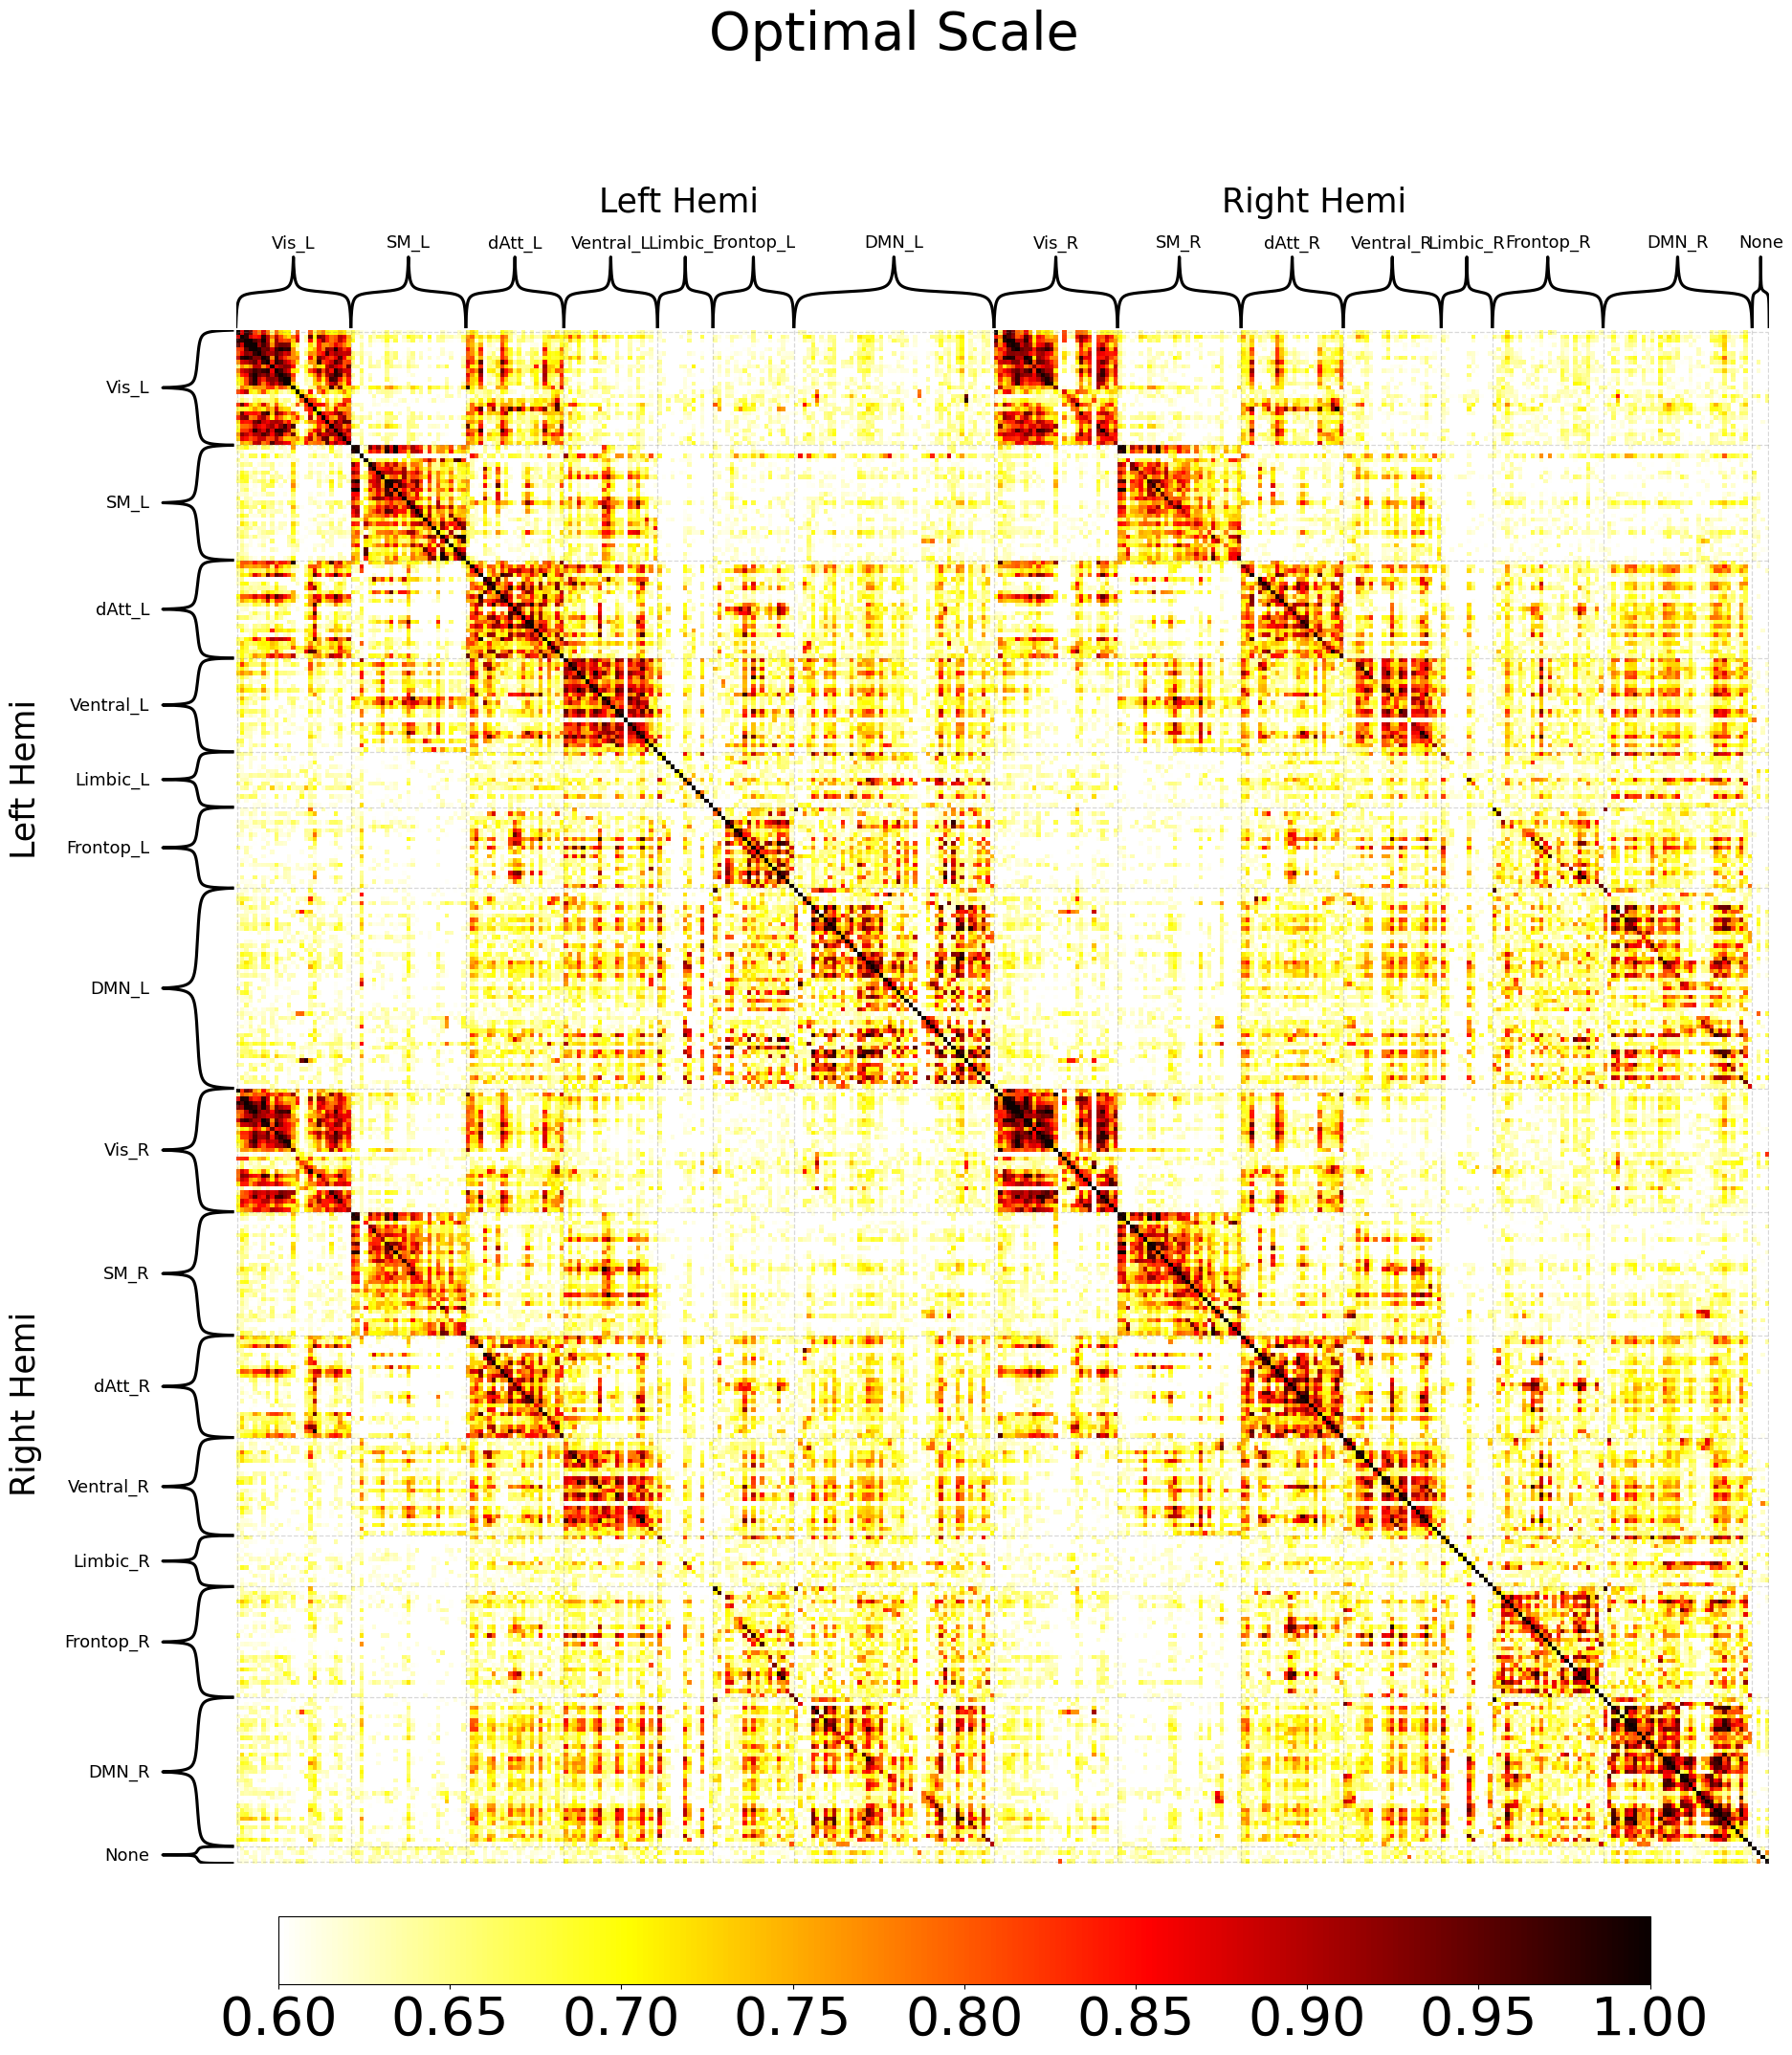

In [ ]:
# # #  # 360 parcels
inner_sort_label = np.flip(np.array(['Vis_L',  'SM_L', 'dAtt_L', 'Ventral_L', 'Limbic_L',  'Frontop_L' ,'DMN_L',
                                     'Vis_R',  'SM_R', 'dAtt_R', 'Ventral_R', 'Limbic_R',  'Frontop_R' ,'DMN_R', 'None']) )
data = np.mean(np.mean([test_mean,retest_mean], axis = 0),axis = 0)

plot_seperate_hemi_heatmap_no_space(data,vmin = 0.6, vmax = 1, cmap='hot_r',title='Optimal scale', inner_sort_label =inner_sort_label, roi_label_all = roi_labels_rename_all_sep)
# plot_seperate_hemi_heatmap_no_space(data,vmin = -0.8, vmax = 0.8, cmap='RdBu_r', title='Pearson's r', inner_sort_label =inner_sort_label, roi_label_all = roi_labels_rename_all_sep)
# plot_seperate_hemi_heatmap_no_space(data,vmin = 0, vmax = 0.5, cmap='Reds', title='MGC Statistics', inner_sort_label =inner_sort_label, roi_label_all = roi_labels_rename_all_sep)


# Fig 1C and Fig 2. similarity

In [ ]:

#  200TR combining test-retest: 30sub*8ses = 240 ses
test_statistic_each_sub = []
pearson_corr_each_sub = []
optimal_scale_X_each_sub = []
for ses_i, ses_id in enumerate(ses):
    for sub_index in range(sub_list_length):
      test_statistic_each_sub.append(test_statistic_each_sub_ses_test[ses_i][sub_index])
      pearson_corr_each_sub.append(np.abs(pearson_corr_each_sub_ses_test[ses_i][sub_index]))
      optimal_scale_X_each_sub.append(optimal_scale_X_each_sub_ses_test[ses_i][sub_index])
for ses_i, ses_id in enumerate(ses):
    for sub_index in range(sub_list_length):
      test_statistic_each_sub.append(test_statistic_each_sub_ses_retest[ses_i][sub_index])
      pearson_corr_each_sub.append(np.abs(pearson_corr_each_sub_ses_retest[ses_i][sub_index]))
      optimal_scale_X_each_sub.append(optimal_scale_X_each_sub_ses_retest[ses_i][sub_index])
'''
#  400TR 30sub*4ses (avg two sessions) = 120 ses
test_statistic_each_sub = []
pearson_corr_each_sub = []
optimal_scale_X_each_sub = []
for ses_i, ses_id in enumerate(ses):
    for sub_index in range(sub_list_length):
      if ses_i == 0 or ses_i == 2:
        mean_two_ses = np.mean([test_statistic_each_sub_ses_test[ses_i][sub_index], test_statistic_each_sub_ses_test[ses_i+1][sub_index]],axis=0)
        test_statistic_each_sub.append(mean_two_ses)
        mean_two_ses = np.mean([np.abs(pearson_corr_each_sub_ses_test[ses_i][sub_index]), np.abs(pearson_corr_each_sub_ses_test[ses_i+1][sub_index])],axis=0)
        pearson_corr_each_sub.append(mean_two_ses)
        mean_two_ses = np.mean([optimal_scale_X_each_sub_ses_test[ses_i][sub_index], optimal_scale_X_each_sub_ses_test[ses_i+1][sub_index]],axis=0)
        optimal_scale_X_each_sub.append(mean_two_ses)
      else:
        continue
for ses_i, ses_id in enumerate(ses):
    for sub_index in range(sub_list_length):
      if ses_i == 0 or ses_i == 2:
        mean_two_ses = np.mean([test_statistic_each_sub_ses_retest[ses_i][sub_index], test_statistic_each_sub_ses_retest[ses_i+1][sub_index]],axis=0)
        test_statistic_each_sub.append(mean_two_ses)
        mean_two_ses = np.mean([np.abs(pearson_corr_each_sub_ses_retest[ses_i][sub_index]), np.abs(pearson_corr_each_sub_ses_retest[ses_i+1][sub_index])],axis=0)
        pearson_corr_each_sub.append(mean_two_ses)
        mean_two_ses = np.mean([optimal_scale_X_each_sub_ses_retest[ses_i][sub_index], optimal_scale_X_each_sub_ses_retest[ses_i+1][sub_index]],axis=0)
        optimal_scale_X_each_sub.append(mean_two_ses)
      else:
        continue

#  800 TR 30sub*2ses (avg 4 sessions) = 60 ses
test_statistic_each_sub = np.append(np.mean(test_statistic_each_sub_ses_test,axis=0),np.mean(test_statistic_each_sub_ses_retest,axis=0),axis=0)
pearson_corr_each_sub = np.append(np.mean(np.abs(pearson_corr_each_sub_ses_test),axis=0), np.mean(np.abs(pearson_corr_each_sub_ses_retest),axis=0),axis=0)
optimal_scale_X_each_sub = np.append(np.mean(optimal_scale_X_each_sub_ses_test,axis=0), np.mean(optimal_scale_X_each_sub_ses_retest,axis=0),axis=0)
'''

"\n#  400TR 30sub*4ses (avg two sessions) = 120 ses\n# ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR', 'rfMRI_REST2_RL']\ntest_statistic_each_sub = []\npearson_corr_each_sub = []\noptimal_scale_X_each_sub = []\nfor ses_i, ses_id in enumerate(ses):\n    for sub_index in range(sub_list_length):\n      if ses_i == 0 or ses_i == 2:\n        mean_two_ses = np.mean([test_statistic_each_sub_ses_test[ses_i][sub_index], test_statistic_each_sub_ses_test[ses_i+1][sub_index]],axis=0)\n        test_statistic_each_sub.append(mean_two_ses)\n        mean_two_ses = np.mean([np.abs(pearson_corr_each_sub_ses_test[ses_i][sub_index]), np.abs(pearson_corr_each_sub_ses_test[ses_i+1][sub_index])],axis=0)\n        pearson_corr_each_sub.append(mean_two_ses)\n        mean_two_ses = np.mean([optimal_scale_X_each_sub_ses_test[ses_i][sub_index], optimal_scale_X_each_sub_ses_test[ses_i+1][sub_index]],axis=0)\n        optimal_scale_X_each_sub.append(mean_two_ses)\n      else:\n        continue\nfor ses_i, ses_

In [ ]:
sort_label = np.array(['Vis',  'SM', 'dAtt', 'Ventral', 'Frontop' ,'DMN','Limbic'])

line_type = ['Within Network', 'Between Network']

sub_n = len(test_statistic_each_sub)
all_subject_7network = np.random.normal(0.02, 1, size=(len(sort_label), sub_n, 2)).reshape(-1).cumsum().reshape(len(sort_label), -1, 2)
roi_label_com = np.append(roi_labels_rename_l, roi_labels_rename_r)

for line_type_i, line_type_id in enumerate(line_type):
  for ses_i in range(len(test_statistic_each_sub)):
      for i, label in enumerate(sort_label):
        if line_type_id == 'Within Network':
          len_roi = sum(roi_label_com == label)

          test_statistic_data = test_statistic_each_sub[ses_i][roi_label_com == label][:,roi_label_com == label][np.triu_indices(len_roi-1)]
          optimal_scale_X_data = optimal_scale_X_each_sub[ses_i][roi_label_com == label][:,roi_label_com == label][np.triu_indices(len_roi-1)]
          pearson_corr_data = pearson_corr_each_sub[ses_i][roi_label_com == label][:,roi_label_com == label][np.triu_indices(len_roi-1)]
          all_subject_7network[i,ses_i,0] = pearsonr(test_statistic_data,np.abs(pearson_corr_data))[0]
          # all_subject_7network[i,ses_i,0] = pearsonr(optimal_scale_X_data, np.abs(pearson_corr_data))[0]

          # plot value
          # all_subject_7network[i,ses_i,0] = np.mean(optimal_scale_X_each_sub[ses_i][roi_label_com == label][:,roi_label_com == label][np.triu_indices(len_roi-1)])
          # optimal_scale_X_each_sub, pearson_corr_each_sub, test_statistic_each_sub
        elif line_type_id == 'Between Network':

          test_statistic_data = test_statistic_each_sub[ses_i][roi_label_com == label][:,np.where(roi_label_com != label)].flatten()
          optimal_scale_X_data = optimal_scale_X_each_sub[ses_i][roi_label_com == label][:,np.where(roi_label_com != label)].flatten()
          pearson_corr_data = pearson_corr_each_sub[ses_i][roi_label_com == label][:,np.where(roi_label_com != label)].flatten()
          all_subject_7network[i,ses_i,1] = pearsonr(test_statistic_data,np.abs(pearson_corr_data))[0]
          # all_subject_7network[i,ses_i,1] = pearsonr(optimal_scale_X_data, np.abs(pearson_corr_data))[0]
          # plot value
          # all_subject_7network[i,ses_i,1] = np.mean(optimal_scale_X_each_sub[ses_i][roi_label_com == label][:,np.where(roi_label_com != label)].flatten())



In [ ]:
print(np.mean(all_subject_7network[:,:,0]))
print(np.std(all_subject_7network[:,:,0]))
print(np.mean(all_subject_7network[:,:,1]))
print(np.std(all_subject_7network[:,:,1]))

0.888288675898184
0.02071419151069366
0.7958602065687443
0.04168457861695377


In [ ]:
all_subject_7network_200 = all_subject_7network

In [ ]:
all_subject_7network_400 = all_subject_7network

In [ ]:
all_subject_7network_800 = all_subject_7network

In [ ]:
# only one TR
# all_subject_7network_all = all_subject_7network

In [ ]:
sub_n = 240
all_subject_7network_all = np.random.normal(0.02, 1, size=(len(sort_label), sub_n, 6)).reshape(-1).cumsum().reshape(len(sort_label), -1, 6)
all_subject_7network_all.shape

(7, 240, 6)

In [ ]:
all_subject_7network_all[:,:,0] = all_subject_7network_200[:,:,0]
all_subject_7network_all[:,:,1] = np.append(all_subject_7network_400[:,:,0], np.full((7,120),np.nan), axis=1)
all_subject_7network_all[:,:,2] = np.append(all_subject_7network_800[:,:,0], np.full((7,180),np.nan), axis=1)
all_subject_7network_all[:,:,3] = all_subject_7network_200[:,:,1]
all_subject_7network_all[:,:,4] = np.append(all_subject_7network_400[:,:,1], np.full((7,120),np.nan), axis=1)
all_subject_7network_all[:,:,5] = np.append(all_subject_7network_800[:,:,1], np.full((7,180),np.nan), axis=1)

In [ ]:
all_subject_7network_all.shape

(7, 240, 6)

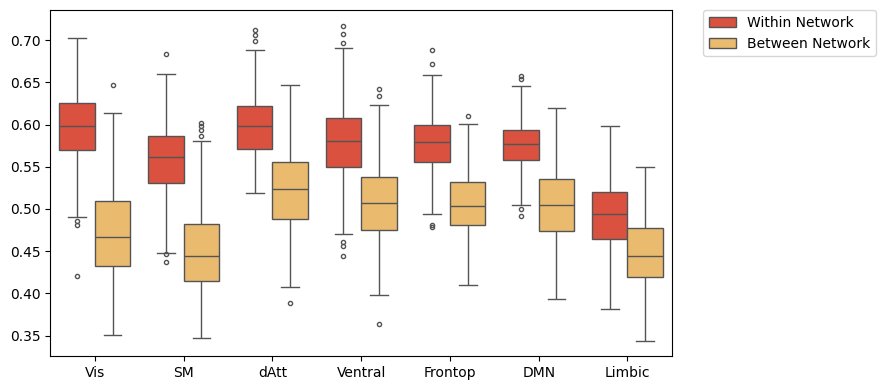

In [ ]:
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(9,4))  #(9,4)
x_names = list(sort_label)
line_type = ['Within Network', 'Between Network']
# line_type = ['Within Network    (200 TR)', 'Within Network    (2 x 200 TR)','Within Network    (4 x 200 TR)',
#              'Between Network (200 TR)', 'Between Network (2 x 200 TR)', 'Between Network (4 x 200 TR)']

hue_names = line_type
dim1, dim2, dim3 = np.meshgrid(x_names, np.arange(all_subject_7network_all.shape[1]), hue_names, indexing='ij',)
pal = sns.color_palette("YlOrRd_r",2) #2 #6
sns.boxplot(x=dim1.ravel(), y=all_subject_7network_all.ravel(), hue=dim3.ravel(),palette=pal,flierprops={"marker": "."}) #,flierprops={"marker": "d"}
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend([],frameon=False)
'''
plt.ylabel("Correlation")
plt.ylim(-0.5,1.1)
'''
# plt.ylabel("Pearson's r") #"Optimal Scale" Pearson's r" "MGC"
# plt.ylim(0.3,1.0)

plt.tight_layout()
plt.show()

# Fig 3. discriminability

In [ ]:
np.array(pearson_corr_each_sub_ses_test).shape

(4, 30, 200, 200)

In [ ]:
# 2 session: 'rfMRI_REST1_LR', 'rfMRI_REST2_LR'
ttest_mean = np.mean([test_statistic_each_sub_ses_test[0],test_statistic_each_sub_ses_test[2]],axis=0)
retest_mean = np.mean([test_statistic_each_sub_ses_retest[0],test_statistic_each_sub_ses_retest[2]],axis=0)

In [ ]:
# # 4 session
# test_mean = np.mean(optimal_scale_X_each_sub_ses_test,axis=0)
# retest_mean = np.mean(optimal_scale_X_each_sub_ses_retest,axis=0)

In [ ]:
np.array(test_mean).shape

(30, 200, 200)

In [ ]:
whole_brain_dis_data = []
for sub_i in range(30):
  a = test_mean[sub_i]
  whole_brain_dis_data.append(a[np.triu_indices(p, k = 1)])
for sub_i in range(30):
  a = retest_mean[sub_i]
  whole_brain_dis_data.append(a[np.triu_indices(p, k = 1)])

In [ ]:
np.array(whole_brain_dis_data).shape

(60, 19900)

In [ ]:
# calculate whole-brain discriminability
from hyppo.discrim import DiscrimOneSample
sub_len = 30
sub=np.concatenate([np.arange(sub_len), np.arange(sub_len)], axis=0) # 2 ses * 30 subjects
# sub=np.concatenate([np.arange(sub_len), np.arange(sub_len), np.arange(sub_len), np.arange(sub_len)], axis=0) # 4 ses * 30 subjects
DiscrimOneSample().test(np.array(whole_brain_dis_data), sub)

(0.9790229885057471, 0.001)

In [ ]:
# discriminability - per parcel
from hyppo.discrim import DiscrimOneSample
# 360*360
DIS_all = []
for parcel_i in range(p):
  dis_data = []
  for sub_i in range(30):
    dis_data.append(test_mean[sub_i][parcel_i])
  for sub_i in range(30):
    dis_data.append(retest_mean[sub_i][parcel_i])
  stat, pvalue = DiscrimOneSample().test(np.array(dis_data), sub)
  DIS_all.append(stat)
DIS_all = np.vstack(DIS_all)

In [ ]:
np.max(DIS_all)

0.8689655172413795

In [ ]:
np.min(DIS_all)


0.47643678160919545

In [ ]:
np.mean(DIS_all)

0.6745086206896552

In [ ]:
np.std(DIS_all)

0.08027321141617665

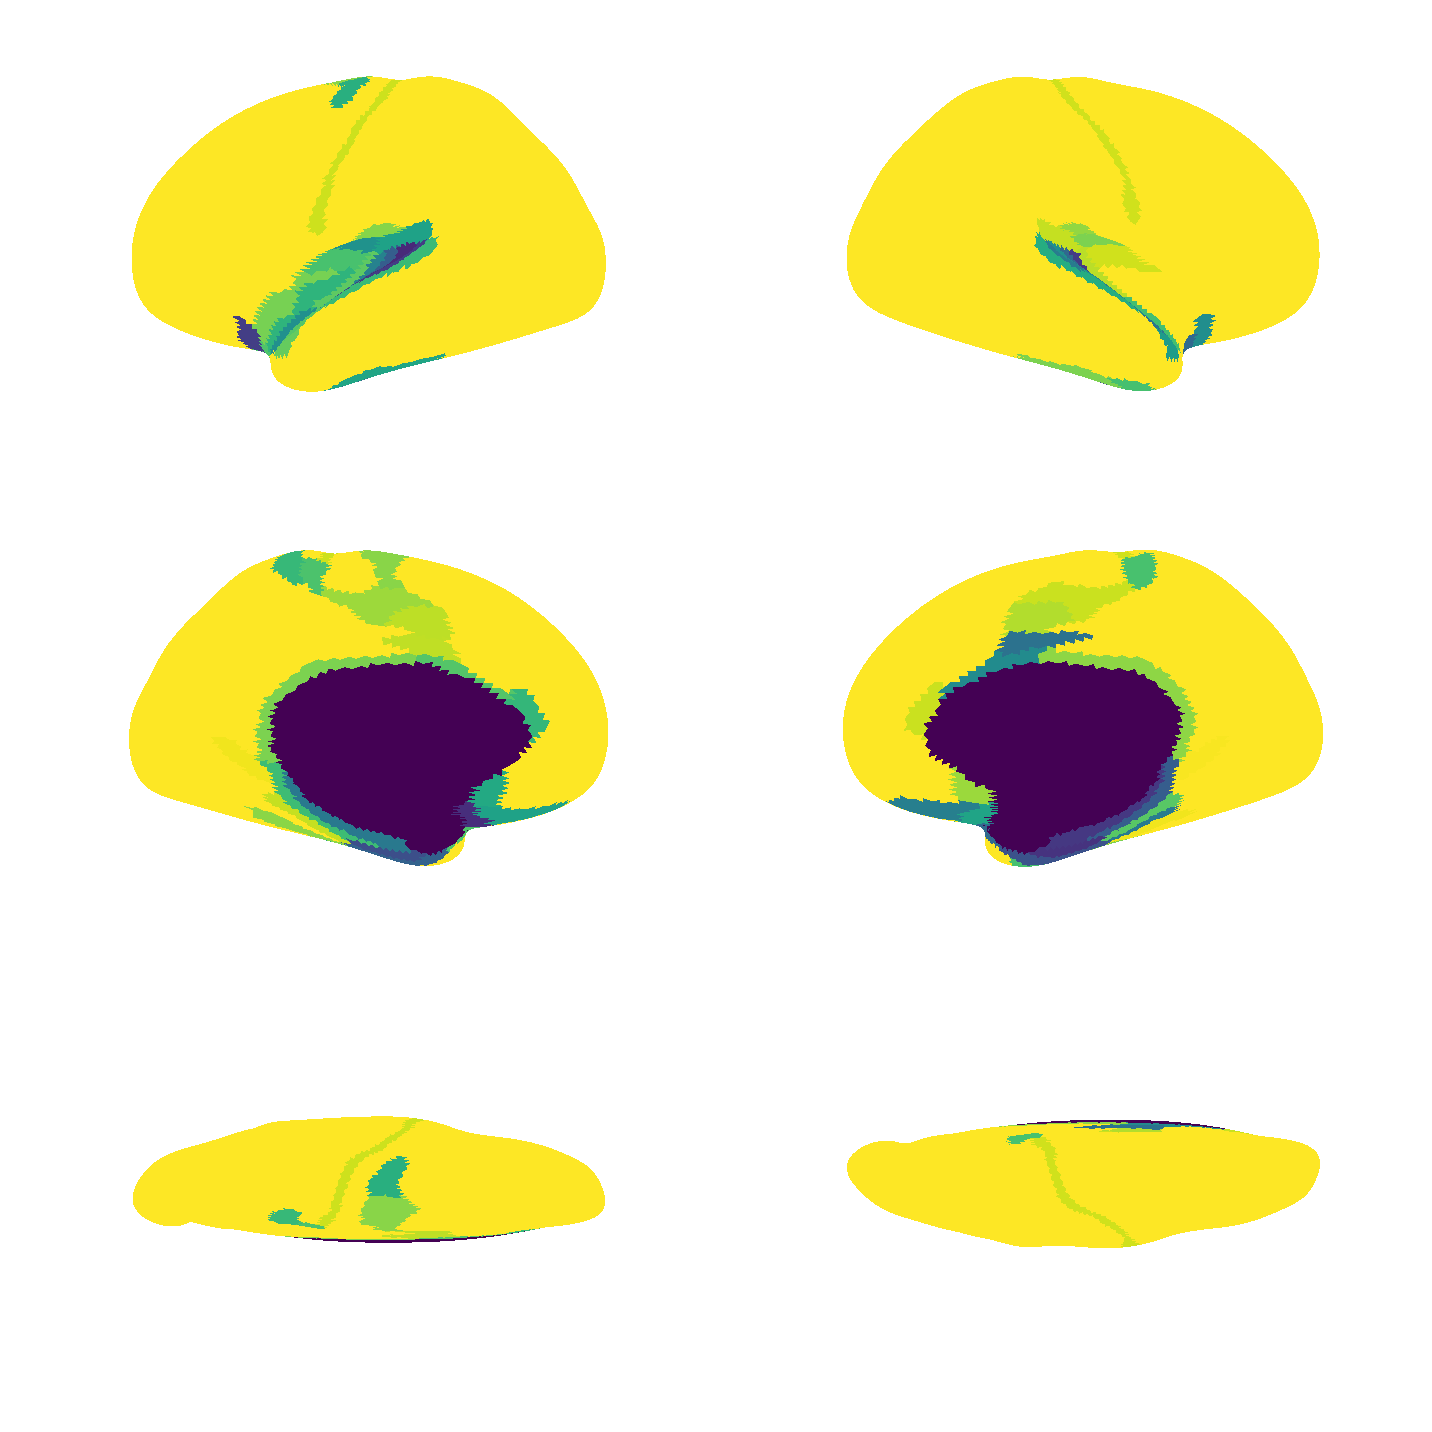

In [ ]:
%matplotlib inline
wdir = '/gdrive/My Drive/CMI/Project/MGCX/data'
parcel_label = plabel = '%s/HCP_MMP_P210_10k.dlabel.nii' % wdir

rightsurface = rsurf='/gdrive/My Drive/CMI/Project/MGCX/data/10k/Conte69.R.very_inflated.10k_fs_LR.surf.gii'
leftsurface = lsurf = '/gdrive/My Drive/CMI/Project/MGCX/data/10k/Conte69.L.very_inflated.10k_fs_LR.surf.gii'

# # dmn
img_ICC = parcel2vert(wdir,lsurf,parcel_label,DIS_all[int(p/2):p].reshape(1,int(p/2)))
img_ICC_r = parcel2vert_r(wdir,rsurf,parcel_label,DIS_all[0:int(p/2)].reshape(1,int(p/2)))

cmap = 'viridis'
vmax = 0.7
vmin = 0.5
j=1
plt.figure(figsize=(20,20))
views = ['lateral', 'medial', 'dorsal']
for v in views:
    ax = plt.subplot(3,2,2*j-1, projection='3d')
    plotting.plot_surf(leftsurface, img_ICC, bg_map=None, hemi='left',view = v, cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 1, symmetric_cmap=False,axes=ax)

    ax = plt.subplot(3,2,2*j, projection='3d')
    plotting.plot_surf(rightsurface, img_ICC_r, bg_map=None, hemi='right',view = v, cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 1, symmetric_cmap=False,axes=ax)

    j+=1

plt.tight_layout()
plt.show()

# Fig 4. Homotopic connectivity

### 30sub*8ses read data

In [ ]:
# 07/18/2022 hcp homo connectivity 180
# 30sub*8ses

p = 180
sub_list_length = 30
tr_list =  [200,400,800]
tr_periord_list = ['0-200', '0-400', '0-800']
sub_id = [103818, 105923, 111312, 114823, 115320, 122317, 125525, 135528, 137128, 139839, 144226, 146129, 149337, 158035, 172332, 177746, 185442, 187547, 192439, 194140, 195041, 200109, 204521, 287248, 601127, 660951, 783462, 859671, 861456, 917255]

M = 0
# Read files and combine into matrix.
trt = ['test', 'retest']
ses = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL','rfMRI_REST2_LR','rfMRI_REST2_RL']

test_statistic_all_TRs = []
optimal_scale_X_all_TRs = []
optimal_scale_Y_all_TRs = []
pearson_corr_all_TRs = []
optimal_scale_X_nonlinear_binary_all_TRs = []
optimal_scale_Y_nonlinear_binary_all_TRs = []

for tr_i, tr_len in enumerate(tr_list):
  tr = tr_len
  # threshold_nonlinear=(tr - np.sqrt(tr))/tr
  threshold_nonlinear=0.95 #5%
  tr_periord = tr_periord_list[tr_i]

  test_statistic_append = []
  optimal_scale_X_append = []
  optimal_scale_Y_append = []
  p_value_append = []
  p_value_sig_binary_append = []
  pearson_corr_append = []
  optimal_scale_X_nonlinear_binary_append = []
  optimal_scale_Y_nonlinear_binary_append = []

  for trt_id in trt:
    for ses_id in ses:
      test_statistic = np.zeros((sub_list_length,p))
      pearson_corr = np.zeros((sub_list_length,p))
      optimal_scale_X = np.zeros((sub_list_length,p))
      optimal_scale_Y = np.zeros((sub_list_length,p))
      optimal_scale_X_nonlinear_binary = np.zeros((sub_list_length,p))
      optimal_scale_Y_nonlinear_binary = np.zeros((sub_list_length,p))

      # gsr
      filename = "/gdrive/My Drive/CMI/Project/MGCX/result/HCP_trt_07012020/homo/30sub/30sub_homo_%s_%s_tr%s_gsr.pkl" % (trt_id,ses_id,tr_periord)
      pickle_in = open(filename,"rb")
      results = np.asarray(pickle.load(pickle_in))
      for result in results:
          # (sub_index, parcel_index, pearson_corr, test_statistic, optimal_scale_X, optimal_scale_Y, p_value)
          k = int(result[0])
          l = int(result[1])
          pearson_corr[k,l] = result[2]
          test_statistic[k,l] = result[3]
          optimal_scale_X[k,l] = result[4] / tr
          optimal_scale_Y[k,l] = result[5] / tr

          if result[4] / tr >= threshold_nonlinear:
            optimal_scale_X_nonlinear_binary[k,l] = 0
          else:
            optimal_scale_X_nonlinear_binary[k,l] = 1

          if result[5] / tr >= threshold_nonlinear:
            optimal_scale_Y_nonlinear_binary[k,l] = 0
          else:
            optimal_scale_Y_nonlinear_binary[k,l] = 1

      test_statistic_append.append(test_statistic)
      optimal_scale_X_append.append(optimal_scale_X)
      optimal_scale_Y_append.append(optimal_scale_Y)
      pearson_corr_append.append(pearson_corr)
      optimal_scale_X_nonlinear_binary_append.append(optimal_scale_X_nonlinear_binary)
      optimal_scale_Y_nonlinear_binary_append.append(optimal_scale_Y_nonlinear_binary)

  test_statistic_all = np.vstack(test_statistic_append)
  optimal_scale_X_all = np.vstack(optimal_scale_X_append)
  optimal_scale_Y_all = np.vstack(optimal_scale_Y_append)
  pearson_corr_all = np.vstack(pearson_corr_append)
  optimal_scale_X_nonlinear_binary_all = np.vstack(optimal_scale_X_nonlinear_binary_append)
  optimal_scale_Y_nonlinear_binary_all = np.vstack(optimal_scale_Y_nonlinear_binary_append)


  test_statistic_all_TRs.append(test_statistic_all)
  optimal_scale_X_all_TRs.append(optimal_scale_X_all)
  optimal_scale_Y_all_TRs.append(optimal_scale_Y_all)
  pearson_corr_all_TRs.append(pearson_corr_all)
  optimal_scale_X_nonlinear_binary_all_TRs.append(optimal_scale_X_nonlinear_binary_all)
  optimal_scale_Y_nonlinear_binary_all_TRs.append(optimal_scale_Y_nonlinear_binary_all)


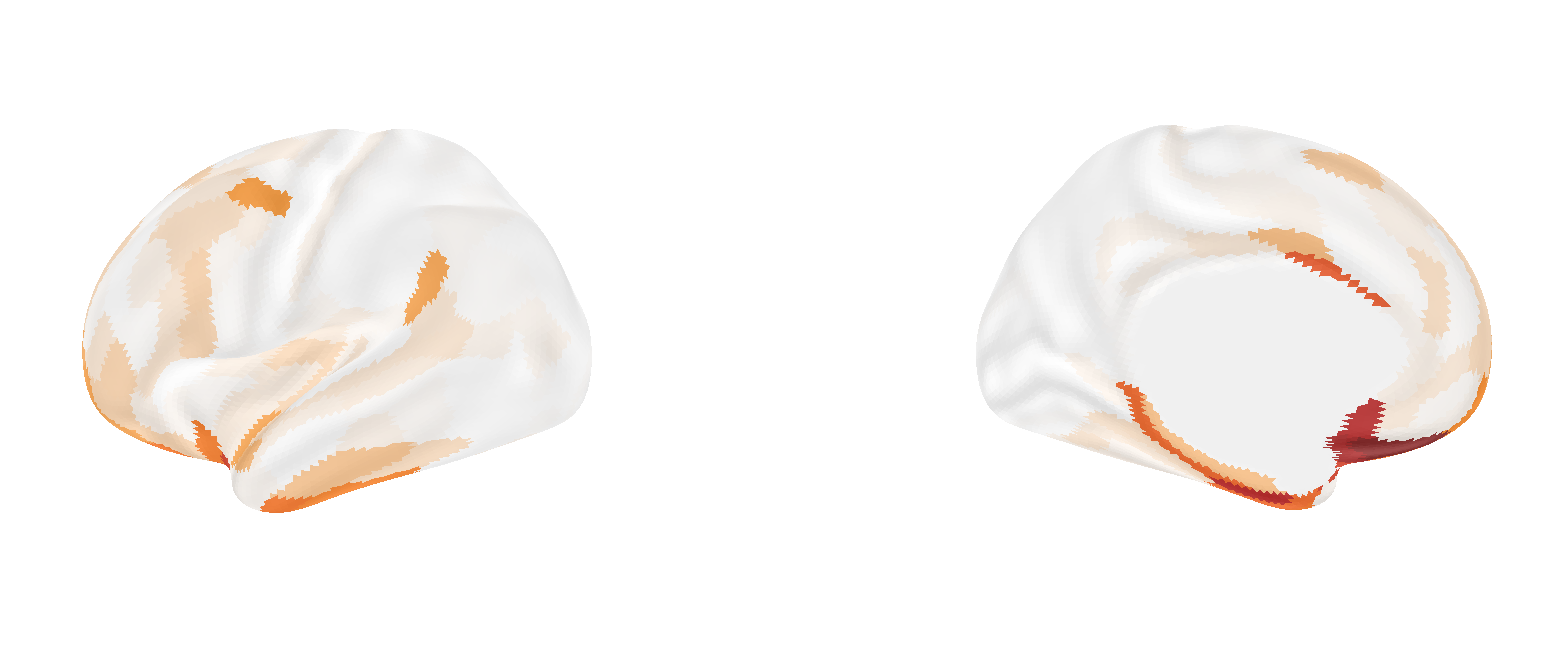

In [ ]:
%matplotlib inline
wdir = '/gdrive/My Drive/CMI/Project/MGCX/data'
parcel_label = plabel = '%s/HCP_MMP_P210_10k.dlabel.nii' % wdir
rightsurface = rsurf='/gdrive/My Drive/CMI/Project/MGCX/data/10k/Conte69.R.very_inflated.10k_fs_LR.surf.gii'
leftsurface = lsurf = '/gdrive/My Drive/CMI/Project/MGCX/data/10k/Conte69.L.very_inflated.10k_fs_LR.surf.gii'

img_optimal_scale_X_mean = parcel2vert(wdir,lsurf,parcel_label,np.mean(optimal_scale_X_nonlinear_binary_all_TRs[2],axis=0).reshape(1,180)) # optimal_scale_Y_all , pearson_corr_all, test_statistic_all

cmap ='gist_heat_r'
# 'gist_heat_r'#'RdBu_r' #'seismic',
# vmax = 0.8 #1
# vmin = -0.8
vmax =  1#1
vmin = 0
j=1
plt.figure(figsize=(20,20/3))
views = ['lateral', 'medial' ] #, 'dorsal']
bg_map = '/gdrive/My Drive/CMI/Project/MGCX/data/10k/S1200.L.curvature_MSMAll.10k_fs_LR.func.gii'

# show left 'lateral', 'medial' 2*1
for v in views:
    ax = plt.subplot(1,2,j, projection='3d') #bg_on_data=False, when plot pearson, R, optimal scale, True, when plot threshold, nonlinear
    plotting.plot_surf(leftsurface, img_optimal_scale_X_mean, bg_map=bg_map, bg_on_data=True,hemi='left',view = v, cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 0.5, symmetric_cmap=False,axes=ax)
    j+=1

plt.tight_layout()
plt.show()





### Fig4B

In [ ]:
cols7 = ((120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (230, 148,  34),
         (205 , 62,  78),
         (253, 255, 208))#  (220 ,248 ,164)
cols = cols7
cols = np.asarray(cols, dtype=float)/255
pal = sns.color_palette(cols)
pal

[(0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 (0.0, 0.4627450980392157, 0.054901960784313725),
 (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 (0.9921568627450981, 1.0, 0.8156862745098039)]

<ipython-input-179-142f67e2a309>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=all_subject_7network_homo.ravel(), y=dim1.ravel(),palette=pal)


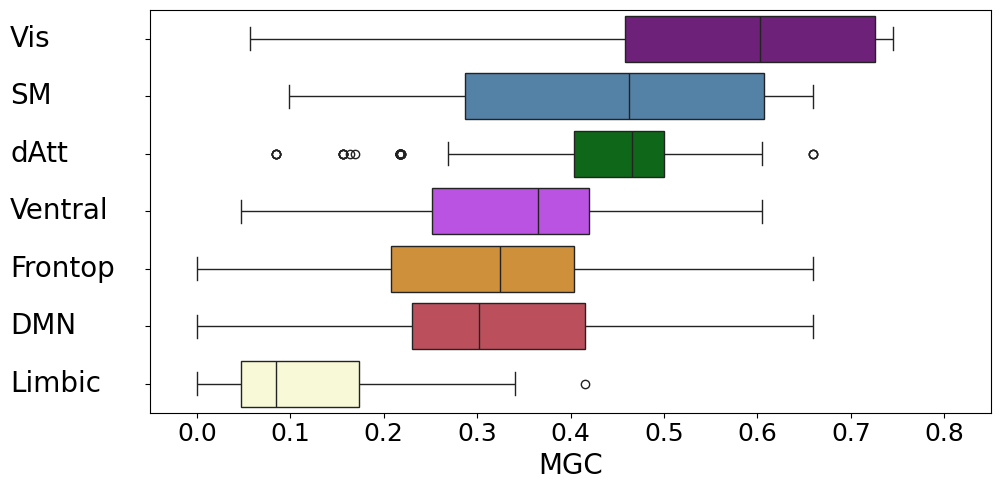

In [ ]:
## plot only on homotopic
# 7network*1avg parcel
sort_label = np.array(['Vis',  'SM', 'dAtt', 'Ventral', 'Frontop' ,'DMN','Limbic'])
sort_label_id = np.array([1,2,3,4,6,7,5])
all_subject_7network_homo = np.full((7, 10000), None)
#test_statistic_all_TRs, pearson_corr_all_TRs, optimal_scale_X_nonlinear_binary_all_TRs
parcel_10k_data = parcel2vert(wdir,lsurf,parcel_label,np.mean(test_statistic_all_TRs[2],axis=0).reshape(1,180))

for i, label in enumerate(sort_label):

  parcel_7network_data = parcel_10k_data[yeo_7network_10k==sort_label_id[i]]
  all_subject_7network_homo[i,0:len(parcel_7network_data)] = parcel_7network_data

x_names = list(sort_label)

fig = plt.figure(figsize=(10,5))  #(9,4) (10,5)
dim1, dim2= np.meshgrid(x_names, np.arange(all_subject_7network_homo.shape[1]), indexing='ij')
ax = sns.boxplot(x=all_subject_7network_homo.ravel(), y=dim1.ravel(),palette=pal)
ax.tick_params(labelsize=18)

y = np.arange(0, 7, 1).tolist()
ax.set_yticks(y)
ax.set_yticklabels([])

for i, yi in enumerate(y):
    ax.text(-0.2, yi, sort_label[i], horizontalalignment='left', verticalalignment='center', size=20)

x = np.arange(0, 1, 0.1).tolist()
ax.set_xticks(x)

ax.set_xlabel("MGC", fontsize=20)#"Optimal Scale" Pearson's r" "MGC" "% of Nonlinear"
ax.set_xlim(-0.05,0.85)
plt.tight_layout()
plt.show()


# Fig 5. monkey HC

In [ ]:
# check paper_public_monkey.ipynb

# heatmap_HJ function

In [ ]:
# Copyright 2019 NeuroData (http://neurodata.io)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.utils import check_array, check_consistent_length
from sklearn.preprocessing import Binarizer


from graspy.embed import selectSVD
from graspy.utils import import_graph, pass_to_ranks


def _check_common_inputs(
    figsize=None,
    height=None,
    title=None,
    context=None,
    font_scale=None,
    legend_name=None,
    title_pad=None,
    hier_label_fontsize=None,
):
    # Handle figsize
    if figsize is not None:
        if not isinstance(figsize, tuple):
            msg = "figsize must be a tuple, not {}.".format(type(figsize))
            raise TypeError(msg)

    # Handle heights
    if height is not None:
        if not isinstance(height, (int, float)):
            msg = "height must be an integer or float, not {}.".format(type(height))
            raise TypeError(msg)

    # Handle title
    if title is not None:
        if not isinstance(title, str):
            msg = "title must be a string, not {}.".format(type(title))
            raise TypeError(msg)

    # Handle context
    if context is not None:
        if not isinstance(context, str):
            msg = "context must be a string, not {}.".format(type(context))
            raise TypeError(msg)
        elif context not in ["paper", "notebook", "talk", "poster"]:
            msg = "context must be one of (paper, notebook, talk, poster), \
                not {}.".format(
                context
            )
            raise ValueError(msg)

    # Handle font_scale
    if font_scale is not None:
        if not isinstance(font_scale, (int, float)):
            msg = "font_scale must be an integer or float, not {}.".format(
                type(font_scale)
            )
            raise TypeError(msg)

    # Handle legend name
    if legend_name is not None:
        if not isinstance(legend_name, str):
            msg = "legend_name must be a string, not {}.".format(type(legend_name))
            raise TypeError(msg)

    if hier_label_fontsize is not None:
        if not isinstance(hier_label_fontsize, (int, float)):
            msg = "hier_label_fontsize must be a scalar, not {}.".format(
                type(legend_name)
            )
            raise TypeError(msg)

    if title_pad is not None:
        if not isinstance(title_pad, (int, float)):
            msg = "title_pad must be a scalar, not {}.".format(type(legend_name))
            raise TypeError(msg)


def _transform(arr, method):
    if method is not None:
        if method in ["log", "log10"]:
            # arr = np.log(arr, where=(arr > 0))
            # hacky, but np.log(arr, where=arr>0) is really buggy
            arr = arr.copy()
            if method == "log":
                arr[arr > 0] = np.log(arr[arr > 0])
            else:
                arr[arr > 0] = np.log10(arr[arr > 0])
        elif method in ["zero-boost", "simple-all", "simple-nonzero"]:
            arr = pass_to_ranks(arr, method=method)
        elif method == "binarize":
            transformer = Binarizer().fit(arr)
            arr = transformer.transform(arr)
        else:
            msg = "Transform must be one of {log, log10, binarize, zero-boost, simple-all, \
            simple-nonzero, not {}.".format(
                method
            )
            raise ValueError(msg)

    return arr


def _process_graphs(
    graphs, inner_sort_label, inner_hier_labels, outer_hier_labels, transform, sort_nodes
):
    """ Handles transformation and sorting of graphs for plotting
    """
    for g in graphs:
        check_consistent_length(g, inner_hier_labels, outer_hier_labels)

    graphs = [_transform(arr, transform) for arr in graphs]

    if inner_hier_labels is not None:
        inner_hier_labels = np.array(inner_hier_labels)
        if outer_hier_labels is None:
            outer_hier_labels = np.ones_like(inner_hier_labels)
        else:
            outer_hier_labels = np.array(outer_hier_labels)
    else:
        inner_hier_labels = np.ones(graphs[0].shape[0], dtype=int)
        outer_hier_labels = np.ones_like(inner_hier_labels)

    graphs = [
        _sort_graph(arr, inner_sort_label, inner_hier_labels, outer_hier_labels, sort_nodes)
        for arr in graphs
    ]
    return graphs


def heatmap_HJ(
    X,
    transform=None,
    figsize=(10, 10),
    title=None,
    context="talk",
    font_scale=1,
    xticklabels=False,
    yticklabels=False,
    cmap="RdBu_r",
    vmin=None,
    vmax=None,
    center=0,
    cbar=True,
    inner_sort_label=None,  #HJ
    inner_hier_labels=None,
    outer_hier_labels=None,
    hier_label_fontsize=30,
    ax=None,
    title_pad=None,
    sort_nodes=False,
    **kwargs
):
    r"""
    Plots a graph as a color-encoded matrix.
    Nodes can be grouped by providing `inner_hier_labels` or both
    `inner_hier_labels` and `outer_hier_labels`. Nodes can also
    be sorted by the degree from largest to smallest degree nodes.
    The nodes will be sorted within each group if labels are also
    provided.
    Read more in the :ref:`tutorials <plot_tutorials>`
    Parameters
    ----------
    X : nx.Graph or np.ndarray object
        Graph or numpy matrix to plot
    transform : None, or string {'log', 'log10', 'zero-boost', 'simple-all', 'simple-nonzero'}
        - 'log'
            Plots the natural log of all nonzero numbers
        - 'log10'
            Plots the base 10 log of all nonzero numbers
        - 'zero-boost'
            Pass to ranks method. preserves the edge weight for all 0s, but ranks
            the other edges as if the ranks of all 0 edges has been assigned.
        - 'simple-all'
            Pass to ranks method. Assigns ranks to all non-zero edges, settling
            ties using the average. Ranks are then scaled by
            :math:`\frac{rank(\text{non-zero edges})}{n^2 + 1}`
            where n is the number of nodes
        - 'simple-nonzero'
            Pass to ranks method. Same as simple-all, but ranks are scaled by
            :math:`\frac{rank(\text{non-zero edges})}{\text{# non-zero edges} + 1}`
        - 'binarize'
            Binarize input graph such that any edge weight greater than 0 becomes 1.
    figsize : tuple of integers, optional, default: (10, 10)
        Width, height in inches.
    title : str, optional, default: None
        Title of plot.
    context :  None, or one of {paper, notebook, talk (default), poster}
        The name of a preconfigured set.
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    xticklabels, yticklabels : bool or list, optional
        If list-like, plot these alternate labels as the ticklabels.
    cmap : str, list of colors, or matplotlib.colors.Colormap, default: 'RdBu_r'
        Valid matplotlib color map.
    vmin, vmax : floats, optional (default=None)
        Values to anchor the colormap, otherwise they are inferred from the data and
        other keyword arguments.
    center : float, default: 0
        The value at which to center the colormap
    cbar : bool, default: True
        Whether to draw a colorbar.
    inner_hier_labels : array-like, length of X's first dimension, default: None
        Categorical labeling of the nodes. If not None, will group the nodes
        according to these labels and plot the labels on the marginal
    outer_hier_labels : array-like, length of X's first dimension, default: None
        Categorical labeling of the nodes, ignored without ``inner_hier_labels``
        If not None, will plot these labels as the second level of a hierarchy on the
        marginals
    hier_label_fontsize : int
        Size (in points) of the text labels for the ``inner_hier_labels`` and
        ``outer_hier_labels``.
    ax : matplotlib Axes, optional
        Axes in which to draw the plot, otherwise will generate its own axes
    title_pad : int, float or None, optional (default=None)
        Custom padding to use for the distance of the title from the heatmap. Autoscales
        if ``None``
    sort_nodes : boolean, optional (default=False)
        Whether or not to sort the nodes of the graph by the sum of edge weights
        (degree for an unweighted graph). If ``inner_hier_labels`` is passed and
        ``sort_nodes`` is ``True``, will sort nodes this way within block.
    **kwargs : dict, optional
        additional plotting arguments passed to Seaborn's ``heatmap``
    """
    _check_common_inputs(
        figsize=figsize,
        title=title,
        context=context,
        font_scale=font_scale,
        hier_label_fontsize=hier_label_fontsize,
        title_pad=title_pad,
    )

    # Handle ticklabels
    if isinstance(xticklabels, list):
        if len(xticklabels) != X.shape[1]:
            msg = "xticklabels must have same length {}.".format(X.shape[1])
            raise ValueError(msg)
    elif not isinstance(xticklabels, bool):
        msg = "xticklabels must be a bool or a list, not {}".format(type(xticklabels))
        raise TypeError(msg)

    if isinstance(yticklabels, list):
        if len(yticklabels) != X.shape[0]:
            msg = "yticklabels must have same length {}.".format(X.shape[0])
            raise ValueError(msg)
    elif not isinstance(yticklabels, bool):
        msg = "yticklabels must be a bool or a list, not {}".format(type(yticklabels))
        raise TypeError(msg)

    # Handle cmap
    if not isinstance(cmap, (str, list, Colormap)):
        msg = "cmap must be a string, list of colors, or matplotlib.colors.Colormap,"
        msg += " not {}.".format(type(cmap))
        raise TypeError(msg)

    # Handle center
    if center is not None:
        if not isinstance(center, (int, float)):
            msg = "center must be a integer or float, not {}.".format(type(center))
            raise TypeError(msg)

    # Handle cbar
    if not isinstance(cbar, bool):
        msg = "cbar must be a bool, not {}.".format(type(center))
        raise TypeError(msg)

    arr = import_graph(X)

    arr = _process_graphs(
        [arr], inner_sort_label, inner_hier_labels, outer_hier_labels, transform, sort_nodes
    )[0]

    # Global plotting settings
    CBAR_KWS = dict(shrink=0.7)  # norm=colors.Normalize(vmin=0, vmax=1))

    with sns.plotting_context(context, font_scale=font_scale):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        plot = sns.heatmap(
            arr,
            cmap=cmap,
            square=True,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws=CBAR_KWS,
            center=center,
            cbar=cbar,
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            **kwargs
        )

        if title is not None:
            if title_pad is None:
                if inner_hier_labels is not None:
                    title_pad = 1.5 * font_scale + 1 * hier_label_fontsize + 30
                else:
                    title_pad = 1.5 * font_scale + 15
            plot.set_title(title, pad=title_pad)
        if inner_hier_labels is not None:
            if outer_hier_labels is not None:
                plot.set_yticklabels([])
                plot.set_xticklabels([])
                _plot_groups(
                    plot,
                    arr,
                    inner_sort_label,
                    inner_hier_labels,
                    outer_hier_labels,
                    fontsize=hier_label_fontsize,
                )
            else:
                _plot_groups(plot, arr, inner_sort_label, inner_hier_labels, fontsize=hier_label_fontsize)
    return plot


def gridplot(
    X,
    labels=None,
    transform=None,
    height=10,
    title=None,
    context="talk",
    font_scale=1,
    alpha=0.7,
    sizes=(10, 200),
    palette="Set1",
    legend_name="Type",
    inner_hier_labels=None,
    outer_hier_labels=None,
    hier_label_fontsize=30,
    title_pad=None,
    sort_nodes=False,
):
    r"""
    Plots multiple graphs on top of each other with dots as edges.
    This function is useful for visualizing multiple graphs simultaneously.
    The size of the dots correspond to the edge weights of the graphs, and
    colors represent input graphs.
    Read more in the :ref:`tutorials <plot_tutorials>`
    Parameters
    ----------
    X : list of nx.Graph or np.ndarray object
        List of nx.Graph or numpy arrays to plot
    labels : list of str
        List of strings, which are labels for each element in X.
        ``len(X) == len(labels)``.
    transform : None, or string {'log', 'log10', 'zero-boost', 'simple-all', 'simple-nonzero'}
        - 'log'
            Plots the natural log of all nonzero numbers
        - 'log10'
            Plots the base 10 log of all nonzero numbers
        - 'zero-boost'
            Pass to ranks method. preserves the edge weight for all 0s, but ranks
            the other edges as if the ranks of all 0 edges has been assigned.
        - 'simple-all'
            Pass to ranks method. Assigns ranks to all non-zero edges, settling
            ties using the average. Ranks are then scaled by
            :math:`\frac{rank(\text{non-zero edges})}{n^2 + 1}`
            where n is the number of nodes
        - 'simple-nonzero'
            Pass to ranks method. Same as simple-all, but ranks are scaled by
            :math:`\frac{rank(\text{non-zero edges})}{\text{# non-zero edges} + 1}`
        - 'binarize'
            Binarize input graph such that any edge weight greater than 0 becomes 1.
    height : int, optional, default: 10
        Height of figure in inches.
    title : str, optional, default: None
        Title of plot.
    context :  None, or one of {paper, notebook, talk (default), poster}
        The name of a preconfigured set.
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    palette : str, dict, optional, default: 'Set1'
        Set of colors for mapping the ``hue`` variable. If a dict, keys should
        be values in the hue variable
    alpha : float [0, 1], default : 0.7
        Alpha value of plotted gridplot points
    sizes : length 2 tuple, default: (10, 200)
        Min and max size to plot edge weights
    legend_name : string, default: 'Type'
        Name to plot above the legend
    inner_hier_labels : array-like, length of X's first dimension, default: None
        Categorical labeling of the nodes. If not None, will group the nodes
        according to these labels and plot the labels on the marginal
    outer_hier_labels : array-like, length of X's first dimension, default: None
        Categorical labeling of the nodes, ignored without ``inner_hier_labels``
        If not None, will plot these labels as the second level of a hierarchy on the
        marginals
    hier_label_fontsize : int
        Size (in points) of the text labels for the ``inner_hier_labels`` and
        ``outer_hier_labels``.
    title_pad : int, float or None, optional (default=None)
        Custom padding to use for the distance of the title from the heatmap. Autoscales
        if ``None``
    sort_nodes : boolean, optional (default=False)
        Whether or not to sort the nodes of the graph by the sum of edge weights
        (degree for an unweighted graph). If ``inner_hier_labels`` is passed and
        ``sort_nodes`` is ``True``, will sort nodes this way within block.
    """
    _check_common_inputs(
        height=height,
        title=title,
        context=context,
        font_scale=font_scale,
        hier_label_fontsize=hier_label_fontsize,
        title_pad=title_pad,
    )

    if isinstance(X, list):
        graphs = [import_graph(x) for x in X]
    else:
        msg = "X must be a list, not {}.".format(type(X))
        raise TypeError(msg)

    if labels is None:
        labels = np.arange(len(X))

    check_consistent_length(X, labels)

    graphs = _process_graphs(
        X, inner_hier_labels, outer_hier_labels, transform, sort_nodes
    )

    if isinstance(palette, str):
        palette = sns.color_palette(palette, desat=0.75, n_colors=len(labels))

    dfs = []
    for idx, graph in enumerate(graphs):
        rdx, cdx = np.where(graph > 0)
        weights = graph[(rdx, cdx)]
        df = pd.DataFrame(
            np.vstack([rdx + 0.5, cdx + 0.5, weights]).T,
            columns=["rdx", "cdx", "Weights"],
        )
        df[legend_name] = [labels[idx]] * len(cdx)
        dfs.append(df)

    df = pd.concat(dfs, axis=0)

    with sns.plotting_context(context, font_scale=font_scale):
        sns.set_style("white")
        plot = sns.relplot(
            data=df,
            x="cdx",
            y="rdx",
            hue=legend_name,
            size="Weights",
            sizes=sizes,
            alpha=alpha,
            palette=palette,
            height=height,
            facet_kws={
                "sharex": True,
                "sharey": True,
                "xlim": (0, graph.shape[0] + 1),
                "ylim": (0, graph.shape[0] + 1),
            },
        )
        plot.ax.axis("off")
        plot.ax.invert_yaxis()
        if title is not None:
            if title_pad is None:
                if inner_hier_labels is not None:
                    title_pad = 1.5 * font_scale + 1 * hier_label_fontsize + 30
                else:
                    title_pad = 1.5 * font_scale + 15
            plt.title(title, pad=title_pad)
    if inner_hier_labels is not None:
        if outer_hier_labels is not None:
            _plot_groups(
                plot.ax,
                graphs[0],
                inner_hier_labels,
                outer_hier_labels,
                fontsize=hier_label_fontsize,
            )
        else:
            _plot_groups(
                plot.ax, graphs[0], inner_hier_labels, fontsize=hier_label_fontsize
            )
    return plot


def pairplot(
    X,
    labels=None,
    col_names=None,
    title=None,
    legend_name=None,
    variables=None,
    height=2.5,
    context="talk",
    font_scale=1,
    palette="Set1",
    alpha=0.7,
    size=50,
    marker=".",
    diag_kind="auto",
):
    r"""
    Plot pairwise relationships in a dataset.
    By default, this function will create a grid of Axes such that each dimension
    in data will by shared in the y-axis across a single row and in the x-axis
    across a single column.

    The off-diagonal Axes show the pairwise relationships displayed as scatterplot.
    The diagonal Axes show the univariate distribution of the data for that
    dimension displayed as either a histogram or kernel density estimates (KDEs).
    Read more in the :ref:`tutorials <plot_tutorials>`
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data.
    labels : array-like or list, shape (n_samples), optional
        Labels that correspond to each sample in X.
    col_names : array-like or list, shape (n_features), optional
        Names or labels for each feature in X. If not provided, the default
        will be `Dimension 1, Dimension 2, etc`.
    title : str, optional, default: None
        Title of plot.
    legend_name : str, optional, default: None
        Title of the legend.
    variables : list of variable names, optional
        Variables to plot based on col_names, otherwise use every column with
        a numeric datatype.
    height : int, optional, default: 10
        Height of figure in inches.
    context :  None, or one of {paper, notebook, talk (default), poster}
        The name of a preconfigured set.
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    palette : str, dict, optional, default: 'Set1'
        Set of colors for mapping the ``hue`` variable. If a dict, keys should
        be values in the hue variable.
    alpha : float, optional, default: 0.7
        Opacity value of plotter markers between 0 and 1
    size : float or int, optional, default: 50
        Size of plotted markers.
    marker : string, optional, default: '.'
        Matplotlib style marker specification
        https://matplotlib.org/api/markers_api.html
    """
    _check_common_inputs(
        height=height,
        title=title,
        context=context,
        font_scale=font_scale,
        legend_name=legend_name,
    )

    # Handle X
    if not isinstance(X, (list, np.ndarray)):
        msg = "X must be array-like, not {}.".format(type(X))
        raise TypeError(msg)

    # Handle Y
    if labels is not None:
        if not isinstance(labels, (list, np.ndarray)):
            msg = "Y must be array-like or list, not {}.".format(type(labels))
            raise TypeError(msg)
        elif X.shape[0] != len(labels):
            msg = "Expected length {}, but got length {} instead for Y.".format(
                X.shape[0], len(labels)
            )
            raise ValueError(msg)

    # Handle col_names
    if col_names is None:
        col_names = ["Dimension {}".format(i) for i in range(1, X.shape[1] + 1)]
    elif not isinstance(col_names, list):
        msg = "col_names must be a list, not {}.".format(type(col_names))
        raise TypeError(msg)
    elif X.shape[1] != len(col_names):
        msg = "Expected length {}, but got length {} instead for col_names.".format(
            X.shape[1], len(col_names)
        )
        raise ValueError(msg)

    # Handle variables
    if variables is not None:
        if len(variables) > len(col_names):
            msg = "variables cannot contain more elements than col_names."
            raise ValueError(msg)
        else:
            for v in variables:
                if v not in col_names:
                    msg = "{} is not a valid key.".format(v)
                    raise KeyError(msg)
    else:
        variables = col_names

    df = pd.DataFrame(X, columns=col_names)
    if labels is not None:
        if legend_name is None:
            legend_name = "Type"
        df_labels = pd.DataFrame(labels, columns=[legend_name])
        df = pd.concat([df_labels, df], axis=1)

        names, counts = np.unique(labels, return_counts=True)
        if counts.min() < 2:
            diag_kind = "hist"
    plot_kws = dict(
        alpha=alpha,
        s=size,
        # edgecolor=None, # could add this latter
        linewidth=0,
        marker=marker,
    )
    with sns.plotting_context(context=context, font_scale=font_scale):
        if labels is not None:
            pairs = sns.pairplot(
                df,
                hue=legend_name,
                vars=variables,
                height=height,
                palette=palette,
                diag_kind=diag_kind,
                plot_kws=plot_kws,
            )
        else:
            pairs = sns.pairplot(
                df,
                vars=variables,
                height=height,
                palette=palette,
                diag_kind=diag_kind,
                plot_kws=plot_kws,
            )
        pairs.set(xticks=[], yticks=[])
        pairs.fig.subplots_adjust(top=0.945)
        pairs.fig.suptitle(title)

    return pairs


def _distplot(
    data,
    labels=None,
    direction="out",
    title="",
    context="talk",
    font_scale=1,
    figsize=(10, 5),
    palette="Set1",
    xlabel="",
    ylabel="Density",
):

    plt.figure(figsize=figsize)
    ax = plt.gca()
    palette = sns.color_palette(palette)
    plt_kws = {"cumulative": True}
    with sns.plotting_context(context=context, font_scale=font_scale):
        if labels is not None:
            categories, counts = np.unique(labels, return_counts=True)
            for i, cat in enumerate(categories):
                cat_data = data[np.where(labels == cat)]
                if counts[i] > 1 and cat_data.min() != cat_data.max():
                    x = np.sort(cat_data)
                    y = np.arange(len(x)) / float(len(x))
                    plt.plot(x, y, label=cat, color=palette[i])
                else:
                    ax.axvline(cat_data[0], label=cat, color=palette[i])
            plt.legend()
        else:
            if data.min() != data.max():
                sns.distplot(data, hist=False, kde_kws=plt_kws)
            else:
                ax.axvline(data[0])

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    return ax


def degreeplot(
    X,
    labels=None,
    direction="out",
    title="Degree plot",
    context="talk",
    font_scale=1,
    figsize=(10, 5),
    palette="Set1",
):
    r"""
    Plots the distribution of node degrees for the input graph.
    Allows for sets of node labels, will plot a distribution for each
    node category.
    Parameters
    ----------
    X : np.ndarray (2D)
        input graph
    labels : 1d np.ndarray or list, same length as dimensions of X
        Labels for different categories of graph nodes
    direction : string, ('out', 'in')
        Whether to plot out degree or in degree for a directed graph
    title : string, default : 'Degree plot'
        Plot title
    context :  None, or one of {talk (default), paper, notebook, poster}
        Seaborn plotting context
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    palette : str, dict, optional, default: 'Set1'
        Set of colors for mapping the ``hue`` variable. If a dict, keys should
        be values in the hue variable.
    figsize : tuple of length 2, default (10, 5)
        Size of the figure (width, height)
    Returns
    -------
    ax : matplotlib axis object
        Output plot
    """
    _check_common_inputs(
        figsize=figsize, title=title, context=context, font_scale=font_scale
    )
    check_array(X)
    if direction == "out":
        axis = 0
        check_consistent_length((X, labels))
    elif direction == "in":
        axis = 1
        check_consistent_length((X.T, labels))
    else:
        raise ValueError('direction must be either "out" or "in"')
    degrees = np.count_nonzero(X, axis=axis)
    ax = _distplot(
        degrees,
        labels=labels,
        title=title,
        context=context,
        font_scale=font_scale,
        figsize=figsize,
        palette=palette,
        xlabel="Node degree",
    )
    return ax


def edgeplot(
    X,
    labels=None,
    nonzero=False,
    title="Edge plot",
    context="talk",
    font_scale=1,
    figsize=(10, 5),
    palette="Set1",
):
    r"""
    Plots the distribution of edge weights for the input graph.
    Allows for sets of node labels, will plot edge weight distribution
    for each node category.
    Parameters
    ----------
    X : np.ndarray (2D)
        Input graph
    labels : 1d np.ndarray or list, same length as dimensions of X
        Labels for different categories of graph nodes
    nonzero : boolean, default: False
        Whether to restrict the edgeplot to only the non-zero edges
    title : string, default : 'Edge plot'
        Plot title
    context :  None, or one of {talk (default), paper, notebook, poster}
        Seaborn plotting context
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    palette : str, dict, optional, default: 'Set1'
        Set of colors for mapping the ``hue`` variable. If a dict, keys should
        be values in the hue variable.
    figsize : tuple of length 2, default (10, 5)
        Size of the figure (width, height)
    Returns
    -------
    ax : matplotlib axis object
        Output plot
    """
    _check_common_inputs(
        figsize=figsize, title=title, context=context, font_scale=font_scale
    )
    check_array(X)
    check_consistent_length((X, labels))
    edges = X.ravel()
    labels = np.tile(labels, (1, X.shape[1]))
    labels = labels.ravel()
    if nonzero:
        labels = labels[edges != 0]
        edges = edges[edges != 0]
    ax = _distplot(
        edges,
        labels=labels,
        title=title,
        context=context,
        font_scale=font_scale,
        figsize=figsize,
        palette=palette,
        xlabel="Edge weight",
    )
    return ax


def screeplot(
    X,
    title="Scree plot",
    context="talk",
    font_scale=1,
    figsize=(10, 5),
    cumulative=True,
    show_first=None,
):
    r"""
    Plots the distribution of singular values for a matrix, either showing the
    raw distribution or an empirical CDF (depending on ``cumulative``)
    Parameters
    ----------
    X : np.ndarray (2D)
        Input matrix
    title : string, default : 'Scree plot'
        Plot title
    context :  None, or one of {talk (default), paper, notebook, poster}
        Seaborn plotting context
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    figsize : tuple of length 2, default (10, 5)
        Size of the figure (width, height)
    cumulative : boolean, default: True
        Whether or not to plot a cumulative cdf of singular values
    show_first : int or None, default: None
        Whether to restrict the plot to the first ``show_first`` components
    Returns
    -------
    ax : matplotlib axis object
        Output plot
    """
    _check_common_inputs(
        figsize=figsize, title=title, context=context, font_scale=font_scale
    )
    check_array(X)
    if show_first is not None:
        if not isinstance(show_first, int):
            msg = "show_first must be an int"
            raise TypeError(msg)
    if not isinstance(cumulative, bool):
        msg = "cumulative must be a boolean"
        raise TypeError(msg)
    _, D, _ = selectSVD(X, n_components=X.shape[1], algorithm="full")
    D /= D.sum()
    if cumulative:
        y = np.cumsum(D[:show_first])
    else:
        y = D[:show_first]
    _ = plt.figure(figsize=figsize)
    ax = plt.gca()
    xlabel = "Component"
    ylabel = "Variance explained"
    with sns.plotting_context(context=context, font_scale=font_scale):
        plt.plot(y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    return ax


def _sort_inds(graph, inner_sort_label, inner_labels, outer_labels, sort_nodes):
    sort_df = pd.DataFrame(columns=("inner_labels", "outer_labels"))
    sort_df["inner_labels"] = inner_labels
    sort_df["outer_labels"] = outer_labels
    '''
    HJ modify make it alphabetical
    # get frequencies of the different labels so we can sort by them
    inner_label_counts = _get_freq_vec(inner_labels)
    outer_label_counts = _get_freq_vec(outer_labels)

    # inverse counts so we can sort largest to smallest
    # would rather do it this way so can still sort alphabetical for ties
    sort_df["inner_counts"] = len(inner_labels) - inner_label_counts
    sort_df["outer_counts"] = len(outer_labels) - outer_label_counts
    '''
    sort_df["inner_counts"] = len(inner_labels)
    sort_df["outer_counts"] = len(outer_labels)

    ### HJ add , sort by inner sort label, an array
    if inner_sort_label is not None:
      inner_sort_label_counts=inner_labels
      for i in range(len(inner_sort_label)):
        inner_sort_label_counts = np.where(inner_sort_label_counts == inner_sort_label[i], len(inner_labels)-i, inner_sort_label_counts)
      sort_df['inner_sort_label_counts'] = inner_sort_label_counts
    else:
      sort_df['inner_sort_label_counts'] = len(inner_labels)

    # get node edge sums (not exactly degrees if weighted)
    node_edgesums = graph.sum(axis=1) + graph.sum(axis=0)
    sort_df["node_edgesums"] = node_edgesums.max() - node_edgesums

    if sort_nodes:
        by = [
            "outer_counts",
            "outer_labels",
            "inner_sort_label_counts", #HJ add
            "inner_counts",
            "inner_labels",
            "node_edgesums",
        ]
    else:
        by = ["outer_counts", "outer_labels", "inner_sort_label_counts", "inner_counts", "inner_labels"]
    sort_df.sort_values(by=by, kind="mergesort", inplace=True)

    sorted_inds = sort_df.index.values
    return sorted_inds


def _sort_graph(graph, inner_sort_label, inner_labels, outer_labels, sort_nodes):
    inds = _sort_inds(graph, inner_sort_label, inner_labels, outer_labels, sort_nodes)
    graph = graph[inds, :][:, inds]
    return graph


def _get_freqs(inner_labels, outer_labels=None):
    # use this because unique would give alphabetical
    _, outer_freq = _unique_like(outer_labels)
    outer_freq_cumsum = np.hstack((0, outer_freq.cumsum()))

    # for each group of outer labels, calculate the boundaries of the inner labels
    inner_freq = np.array([])
    for i in range(outer_freq.size):
        start_ind = outer_freq_cumsum[i]
        stop_ind = outer_freq_cumsum[i + 1]
        _, temp_freq = _unique_like(inner_labels[start_ind:stop_ind])
        inner_freq = np.hstack([inner_freq, temp_freq])
    inner_freq_cumsum = np.hstack((0, inner_freq.cumsum()))

    return inner_freq, inner_freq_cumsum, outer_freq, outer_freq_cumsum


def _get_freq_vec(vals):
    # give each set of labels a vector corresponding to its frequency
    _, inv, counts = np.unique(vals, return_counts=True, return_inverse=True)
    count_vec = counts[inv]
    return count_vec


def _unique_like(vals):
    # gives output like
    uniques, inds, counts = np.unique(vals, return_index=True, return_counts=True)
    inds_sort = np.argsort(inds)
    uniques = uniques[inds_sort]
    counts = counts[inds_sort]
    return uniques, counts


# assume that the graph has already been plotted in sorted form
def _plot_groups(ax, graph, inner_sort_label, inner_labels, outer_labels=None, fontsize=30):
    inner_labels = np.array(inner_labels)
    plot_outer = True
    if outer_labels is None:
        outer_labels = np.ones_like(inner_labels)
        plot_outer = False

    sorted_inds = _sort_inds(graph, inner_sort_label, inner_labels, outer_labels, False)
    inner_labels = inner_labels[sorted_inds]
    outer_labels = outer_labels[sorted_inds]

    inner_freq, inner_freq_cumsum, outer_freq, outer_freq_cumsum = _get_freqs(
        inner_labels, outer_labels
    )

    #
    inner_unique, _ = _unique_like(inner_labels)
    outer_unique, _ = _unique_like(outer_labels)

    n_verts = graph.shape[0]
    axline_kws = dict(linestyle="dashed", lw=0.9, alpha=0.3, zorder=3, color="grey")
    # draw lines
    for x in inner_freq_cumsum[1:-1]:
        ax.vlines(x, 0, n_verts + 1, **axline_kws)
        ax.hlines(x, 0, n_verts + 1, **axline_kws)

    # add specific lines for the borders of the plot
    pad = 0.001
    low = pad
    high = 1 - pad
    ax.plot((low, low), (low, high), transform=ax.transAxes, **axline_kws)
    ax.plot((low, high), (low, low), transform=ax.transAxes, **axline_kws)
    ax.plot((high, high), (low, high), transform=ax.transAxes, **axline_kws)
    ax.plot((low, high), (high, high), transform=ax.transAxes, **axline_kws)

    # generic curve that we will use for everything
    lx = np.linspace(-np.pi / 2.0 + 0.05, np.pi / 2.0 - 0.05, 500)
    tan = np.tan(lx)
    curve = np.hstack((tan[::-1], tan))

    divider = make_axes_locatable(ax)

    # inner curve generation
    inner_tick_loc = inner_freq.cumsum() - inner_freq / 2
    inner_tick_width = inner_freq / 2
    # outer curve generation
    outer_tick_loc = outer_freq.cumsum() - outer_freq / 2
    outer_tick_width = outer_freq / 2

    # top inner curves
    ax_x = divider.new_vertical(size="5%", pad=0.0, pack_start=False)
    ax.figure.add_axes(ax_x)
    _plot_brackets(
        ax_x,
        np.tile(inner_unique, len(outer_unique)),
        inner_tick_loc,
        inner_tick_width,
        curve,
        "inner",
        "x",
        n_verts,
        fontsize,
    )
    # side inner curves
    ax_y = divider.new_horizontal(size="5%", pad=0.0, pack_start=True)
    ax.figure.add_axes(ax_y)
    _plot_brackets(
        ax_y,
        np.tile(inner_unique, len(outer_unique)),
        inner_tick_loc,
        inner_tick_width,
        curve,
        "inner",
        "y",
        n_verts,
        fontsize,
    )

    if plot_outer:
        # top outer curves
        pad_scalar = 0.35 / 30 * fontsize
        ax_x2 = divider.new_vertical(size="5%", pad=pad_scalar, pack_start=False)
        ax.figure.add_axes(ax_x2)
        _plot_brackets(
            ax_x2,
            outer_unique,
            outer_tick_loc,
            outer_tick_width,
            curve,
            "outer",
            "x",
            n_verts,
            fontsize,
        )
        # side outer curves
        ax_y2 = divider.new_horizontal(size="5%", pad=pad_scalar, pack_start=True)
        ax.figure.add_axes(ax_y2)
        _plot_brackets(
            ax_y2,
            outer_unique,
            outer_tick_loc,
            outer_tick_width,
            curve,
            "outer",
            "y",
            n_verts,
            fontsize,
        )
    return ax


def _plot_brackets(
    ax, group_names, tick_loc, tick_width, curve, level, axis, max_size, fontsize
):
    for x0, width in zip(tick_loc, tick_width):
        x = np.linspace(x0 - width, x0 + width, 1000)
        if axis == "x":
            ax.plot(x, -curve, c="k")
            ax.patch.set_alpha(0)
        elif axis == "y":
            ax.plot(curve, x, c="k")
            ax.patch.set_alpha(0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis=axis, which=u"both", length=0, pad=7)
    for direction in ["left", "right", "bottom", "top"]:
        ax.spines[direction].set_visible(False)
    if axis == "x":
        ax.set_xticks(tick_loc)
        ax.set_xticklabels(group_names, fontsize=fontsize, verticalalignment="center")
        ax.xaxis.set_label_position("top")
        ax.xaxis.tick_top()
        ax.xaxis.labelpad = 30
        ax.set_xlim(0, max_size)
        ax.tick_params(axis="x", which="major", pad=5 + fontsize / 4)
    elif axis == "y":
        ax.set_yticks(tick_loc)
        ax.set_yticklabels(group_names, fontsize=fontsize, verticalalignment="center")
        ax.set_ylim(0, max_size)
        ax.invert_yaxis()


In [ ]:
def plot_seperate_hemi_heatmap_no_space(data_sep, vmin, vmax, cmap,title, inner_sort_label, roi_label_all):
  heatmap_kws = dict(
      cbar=False,
      font_scale=1,
      inner_sort_label = inner_sort_label,
      hier_label_fontsize=13,
      center=None,
  )
  fig, ax = plt.subplots(1, 1, figsize=(20, 20))
  # SBM
  heatmap_HJ(data_sep, ax=ax, vmin = vmin, vmax = vmax, cmap=cmap, inner_hier_labels=roi_label_all, **heatmap_kws)

  plt.subplots_adjust(bottom=0.1, wspace = 0.025,hspace=0.025)
  ax.set_xlabel('Left Hemi                                            Right Hemi\n\n\n', fontsize =25)
  ax.set_ylabel('Right Hemi                                           Left Hemi\n\n\n\n\n', fontsize =25)
  ax.xaxis.set_label_position('top')

  fig.suptitle(title, fontsize = 40, y=1.05)
  plt.tight_layout()

  # Add colorbar
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbar = fig.colorbar(
      sm, ax=ax, orientation="horizontal", pad=0.03, shrink=0.8, fraction=0.05)#, ticks=[0.6,0.7,0.8,0.9,1]) #ticks for optimal scale
  sm.set_clim(vmin, vmax)
  cbar.ax.tick_params(labelsize=40) #

# Example: Running MGCX

In [ ]:
# check https://github.com/rmehta004/connectomics-with-mgcx/blob/master/code/run-mgcx-hcp.py

In [ ]:
# 05/14/21 HCP trt
# 02/20/22 HCP trt Schaefer parcel
# whole brain

sub_id = [103818, 105923, 111312, 114823, 115320, 122317, 125525, 135528, 137128, 139839, 144226, 146129, 149337, 158035, 172332, 177746, 185442, 187547, 192439, 194140, 195041, 200109, 204521, 287248, 601127, 660951, 783462, 859671, 861456, 917255]
# Parameters.
M = 0
tr = 200

from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr

def worker(ses_id,trt_id,sub_index,parcel_index_x, parcel_index_y):
      # gsr
      #img = nib.load('/gdrive/My Drive/CMI/Project/MGCX/data/HCP_trt/HCP_trt_07012020/%s/%s/%s/gsr/%s_Atlas_MSMAll_hp2000_clean_24nuisance.gsr.reg_lin.trend_filt_sm6.ptseries.nii'% (trt_id,str(sub_id[sub_index]),ses_id,ses_id ))
      img = nib.load('/gdrive/My Drive/CMI/Project/MGCX/data/HCP_trt/HCP_trt_02202022/%s/%s/%s/gsr/%s_Atlas_MSMAll_hp2000_clean_24nuisance.gsr.reg_lin.trend_filt_sm6.Shaefer200_Yeo7.ptseries.nii'% (trt_id,str(sub_id[sub_index]),ses_id,ses_id ))
      data = np.array(img.get_fdata())
      #zscore
      axis= 0
      data = zscore(data,axis=axis)
      X = data[0:tr,parcel_index_x].reshape(tr, 1)
      Y = data[0:tr,parcel_index_y].reshape(tr, 1)

      mgcx = MGCX(max_lag = M)
      test_statistic, metadata = mgcx.test_statistic(X, Y)
      optimal_scale_X = metadata['optimal_scale'][0]
      optimal_scale_Y = metadata['optimal_scale'][1]

      # fast-DCorr
      dcorr = DCorr()
      p_value, p_value_metadata = dcorr.p_value(X,Y,is_fast=True)

      # pearson
      X = data[0:tr,parcel_index_x]  ##pearson delete reshape
      Y = data[0:tr,parcel_index_y]

      pearson_corr, ____= pearsonr(X,Y)

      output = (parcel_index_x, parcel_index_y, pearson_corr, test_statistic, optimal_scale_X, optimal_scale_Y, p_value)

      return(output)

p = 200
trt = ['test']
ses = ['rfMRI_REST1_LR']
#['rfMRI_REST1_LR', 'rfMRI_REST1_RL','rfMRI_REST2_LR','rfMRI_REST2_RL']
sub_id_number_start = 0
sub_id_number_stop =  2 #30
tr_periord = '0-200'

for trt_id in trt:
  for ses_id in ses:
    for sub_index in range(sub_id_number_start, sub_id_number_stop) :
      result = Parallel(n_jobs=180, verbose=10)(delayed(worker)(ses_id,trt_id, sub_index, parcel_index_x,parcel_index_y) for parcel_index_x in range(p) for parcel_index_y in range(p))	#.360 #200
      # gsr
      filename = 'sub-%d_%s_%s_tr%s_gsr.pkl' % (sub_id[sub_index],trt_id,ses_id,tr_periord)

      output_file = open(filename, 'wb')
      pickle.dump(result, output_file)
      output_file.close()

      from google.colab import files
      # gsr
      files.download('sub-%d_%s_%s_tr%s_gsr.pkl' % (sub_id[sub_index],trt_id,ses_id,tr_periord))